In [1]:
import argparse
import random
from typing import Literal
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import intel_extension_for_pytorch as ipex
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from PIL import Image
from PIL.ImageFile import ImageFile

from tqdm import tqdm
from torchvision import transforms as T

random.seed(42)

/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_pth = Path('../../data/extracted_masks')

In [23]:


sample_pth = random.choice(list(data_pth.glob('*')))

In [24]:

sample_pth

PosixPath('../../data/extracted_masks/D2018.04.14_S01766_I0149_D_9')

In [25]:
all_masks = np.load(sample_pth/'zps.npy')
all_masks_inner = np.load(sample_pth/'mask_inner.npy')
all_masks_whole = np.load(sample_pth/'mask_whole.npy')

In [26]:
nframes = all_masks.shape[0]

In [27]:
nframes

183

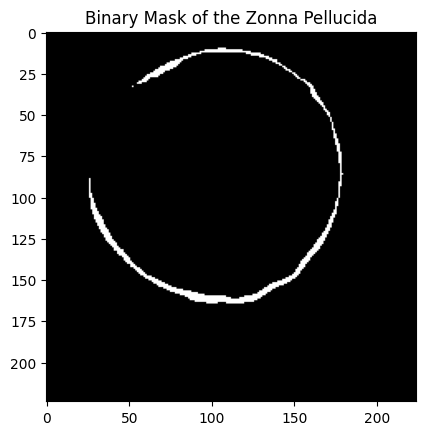

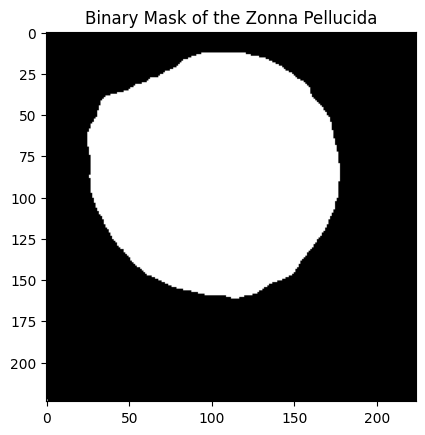

Text(0.5, 1.0, 'Binary Mask of the Zonna Pellucida')

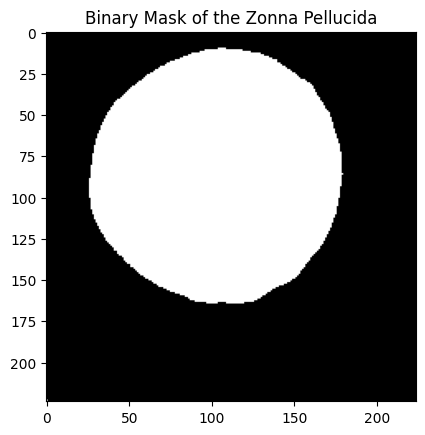

In [28]:
plt.imshow(all_masks[-1][0]==1, cmap='gray')
plt.title("Binary Mask of the Zonna Pellucida")
plt.show()
plt.imshow(all_masks_inner[-1][0]==1, cmap='gray')
plt.title("Binary Mask of the Zonna Pellucida")
plt.show()
plt.imshow(all_masks_whole[-1][0]==1, cmap='gray')
plt.title("Binary Mask of the Zonna Pellucida")

In [29]:
def calculate_radiuses(x_coords, y_coords):
    # Calculate the distances of all white boundary pixels from the circle center
    distances = np.sqrt((x_coords - xc)**2 + (y_coords - yc)**2)
    q_001 = distances>=np.quantile(distances, q=0.1)
    q_099= distances<=np.quantile(distances, q=0.90)
    distances= distances[(q_001&q_099)]
    # Find the "true" outer radius based on the maximal distances (fullest thickness)
    outer_radius = np.max(distances)
    inner_radius = np.min(distances)
    # Compute the thickness as the difference
    thickness_values = distances - radius  # Thickness at each point
    thickness_mean = np.mean(thickness_values[thickness_values > 0])  # Exclude artifacts (negative values)
    thickness_variance = np.var(thickness_values[thickness_values > 0])

    return outer_radius, inner_radius, thickness_mean, thickness_variance, distances


In [30]:
from scipy.optimize import leastsq
def algebraic_circle_fit(x, y):
    """
    Perform least-squares fitting of a circle to given (x, y) points.
    Returns the center (xc, yc) and radius r.
    """
    def calc_radius(xc, yc):
        return np.sqrt((x - xc)**2 + (y - yc)**2)

    def cost(params):
        xc, yc = params
        radii = calc_radius(xc, yc)
        return radii - radii.mean()

    # Initial guess for the center
    x_m, y_m = np.mean(x), np.mean(y)
    center, _ = leastsq(cost, (x_m, y_m))
    xc, yc = center
    radii = calc_radius(xc, yc)
    r = radii.mean()
    return xc, yc, r


In [45]:
# Define the angular intervals for measuring thickness
import numpy as np
angles = np.linspace(0, 2 * np.pi, 360)  # 360 angular intervals
mean_thicknesses = []
radii = []
outter_radii = []
circle_centers = []
area = []
for i in range(nframes):
    thicknesses = []
    binary = all_masks[i,0]==1

    area.append((all_masks_whole[i,0]==1).sum())

    y_coords, x_coords = np.where(binary == True)

    xc, yc, radius = algebraic_circle_fit(x_coords, y_coords)


    outer_radius, inner_radius, thickness_mean, thickness_variance, distances = calculate_radiuses(x_coords, y_coords)
    
    # Iterate over each angle and calculate true thickness
    for angle in angles:
        # Compute ray endpoints based on the angle
        ray_x = int(xc + outer_radius * np.cos(angle))
        ray_y = int(yc + outer_radius * np.sin(angle))
        
        # Traverse along the ray to find outer and inner boundary points
        points_on_ray = []
        for t in np.linspace(0, outer_radius, 500):
            x = int(xc + t * np.cos(angle))
            y = int(yc + t * np.sin(angle))
            if 0 <= x < binary.shape[1] and 0 <= y < binary.shape[0]:
                if binary[y, x] == True:
                    points_on_ray.append((x, y))
        
        # If points are found, calculate distances to the center
        if len(points_on_ray) > 1:
            distances = [np.sqrt((px - xc)**2 + (py - yc)**2) for px, py in points_on_ray]
            thickness = max(distances) - min(distances)  # True thickness
            thicknesses.append(thickness)
        else:
            continue
    

    mean_thicknesses.append((np.mean(thicknesses), np.std(thicknesses)))
    radii.append(inner_radius)
    outter_radii.append(outer_radius)
    circle_centers.append((xc,yc))
    # Convert angles to degrees for plotting
    angles_deg = np.degrees(angles)

    # Plot the thickness profile
    # plt.figure(figsize=(8, 4))
    # plt.plot(angles_deg, thicknesses)
    
# plt.xlabel("Angle (degrees)")
# plt.ylabel("True Thickness (pixels)")
# plt.title("True Thickness Along the Circle")
# plt.grid(True)
# plt.show()


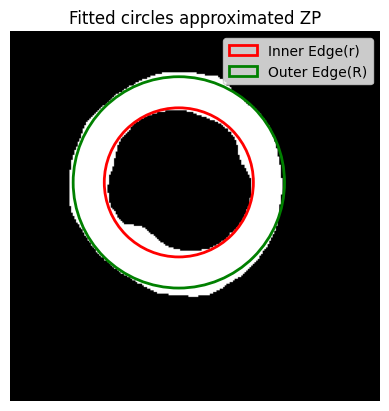

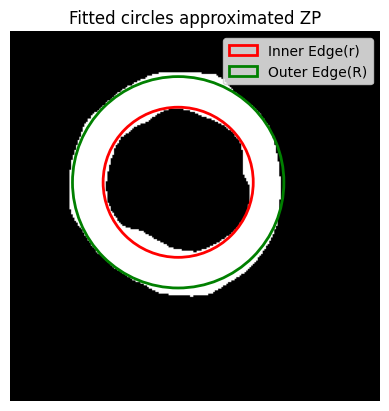

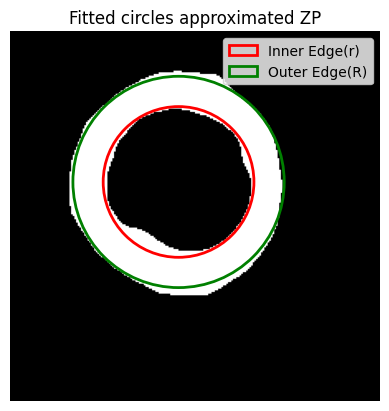

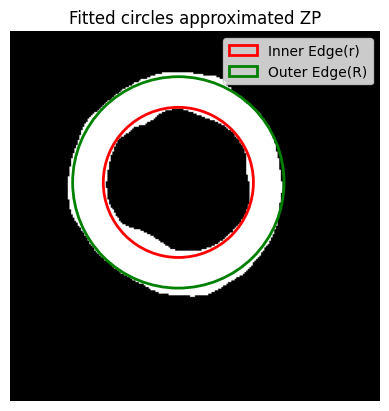

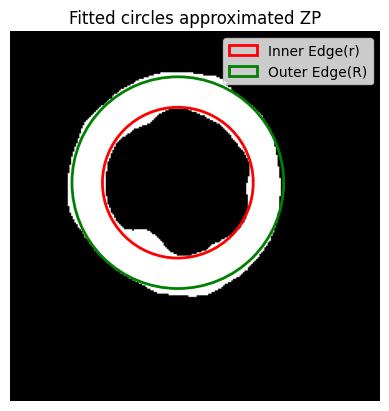

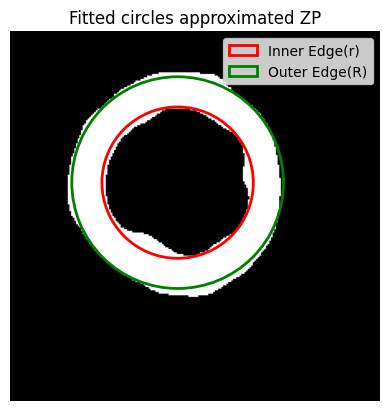

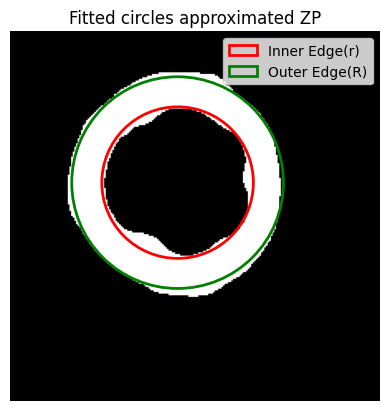

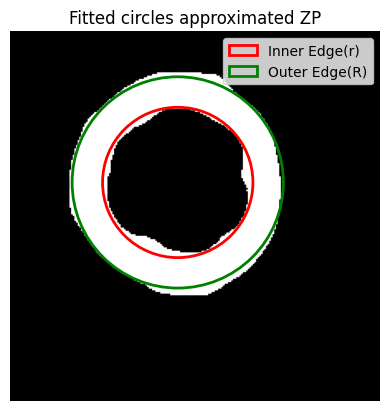

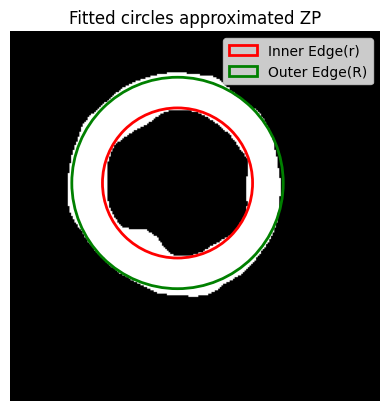

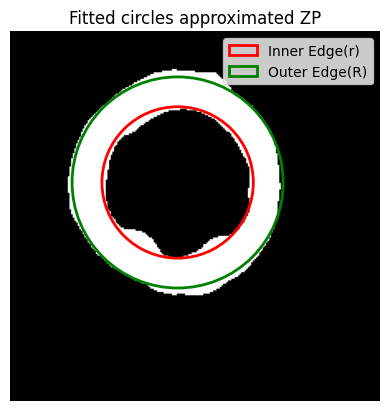

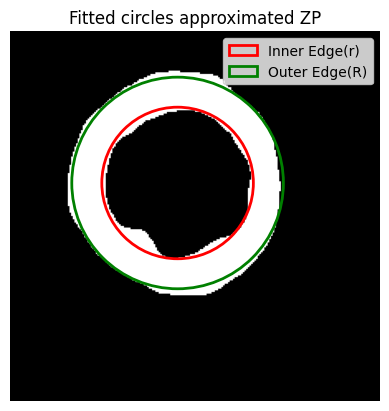

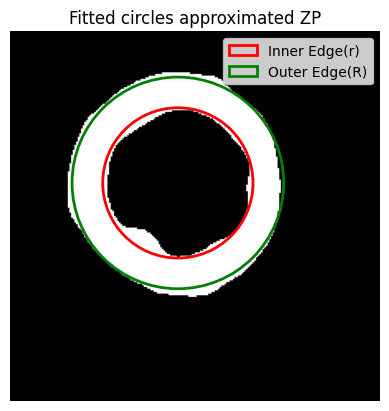

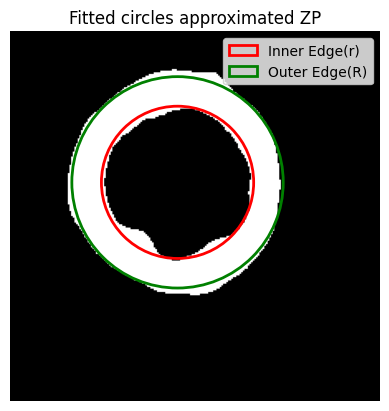

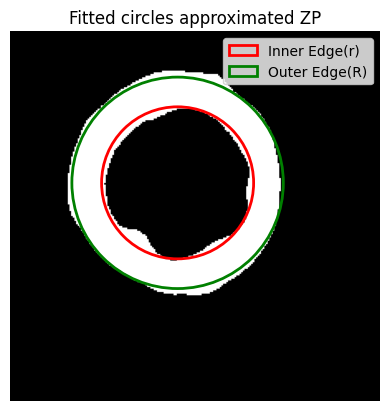

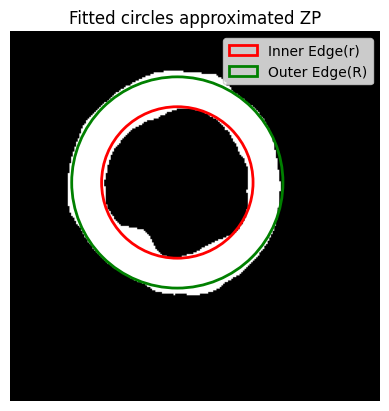

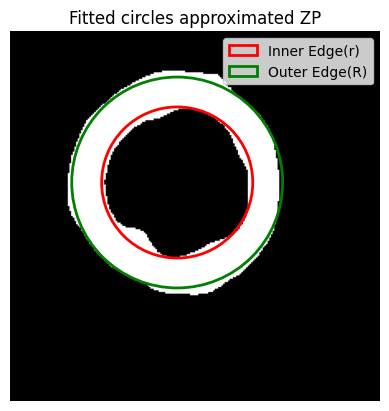

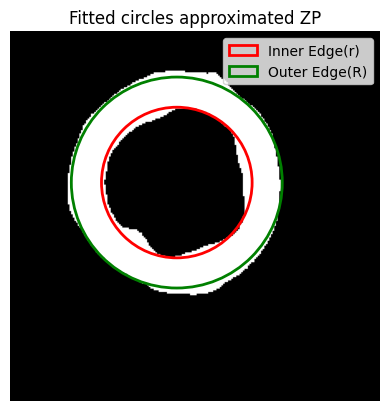

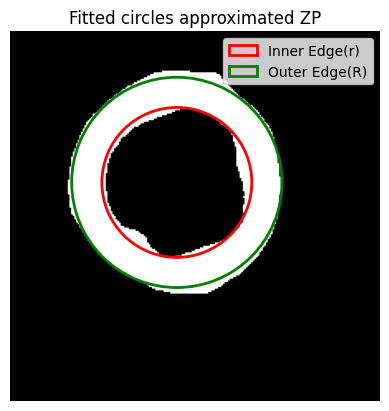

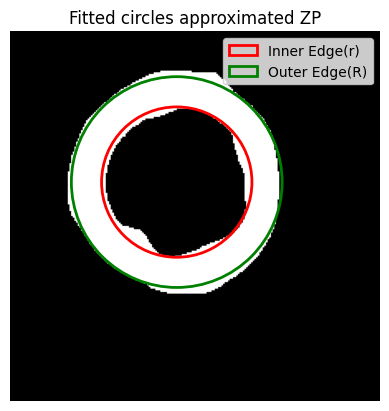

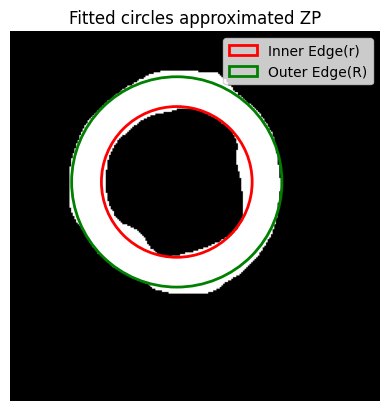

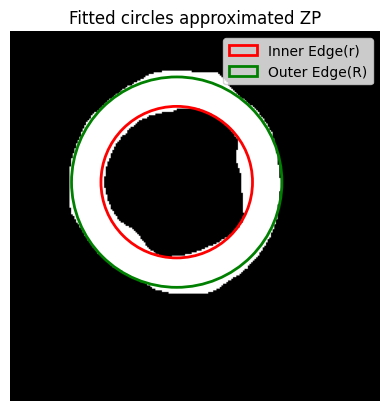

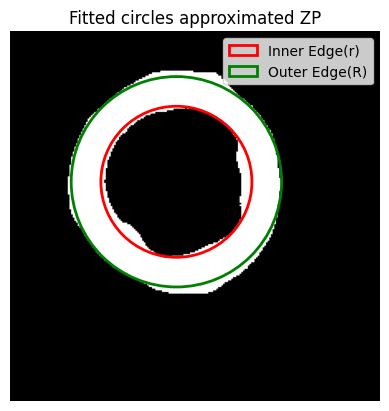

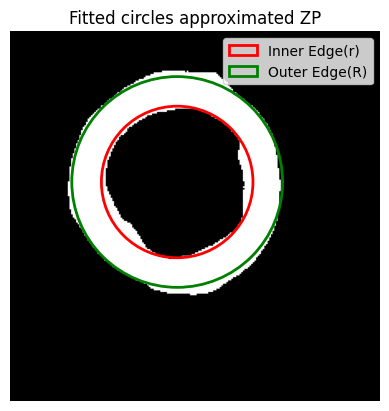

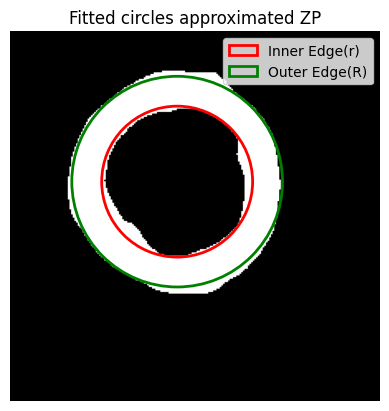

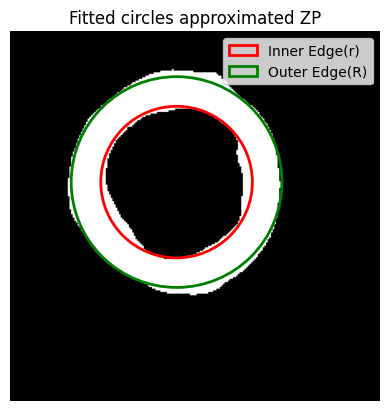

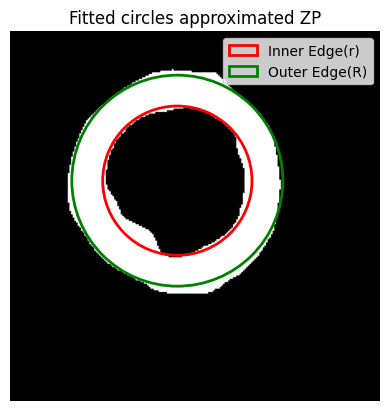

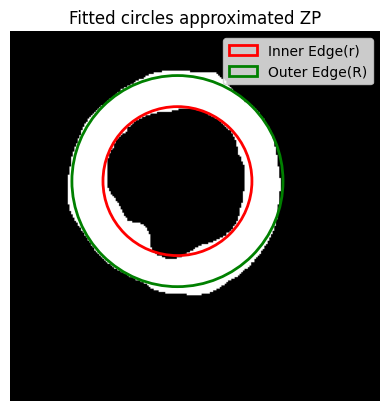

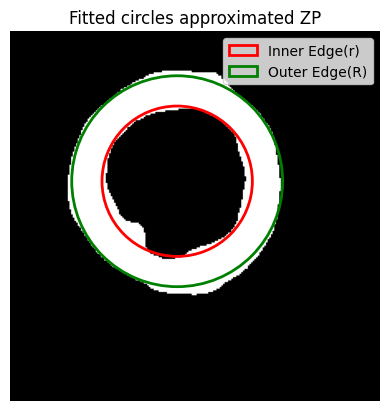

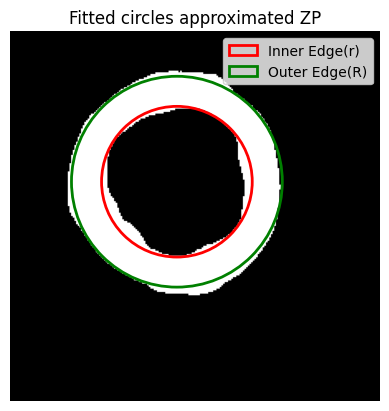

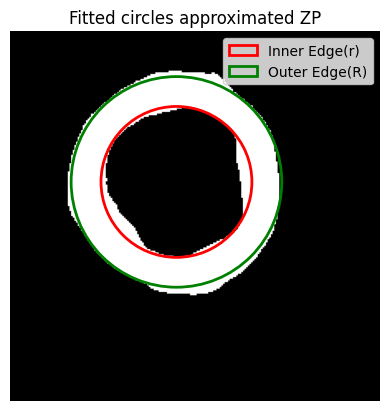

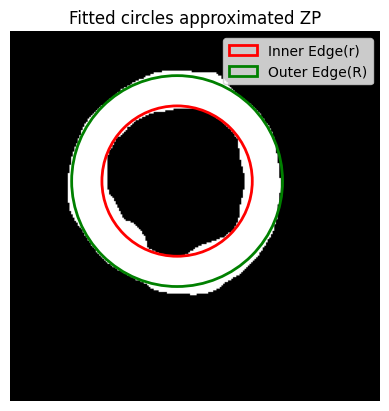

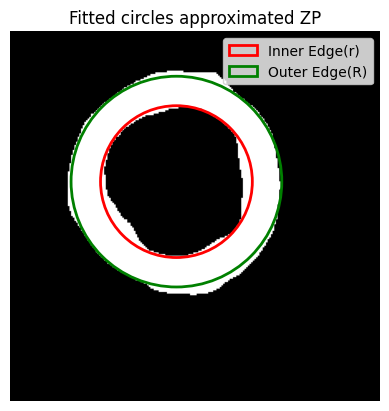

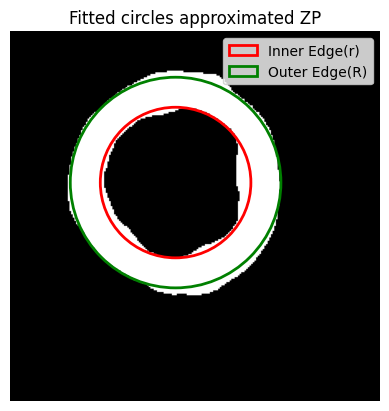

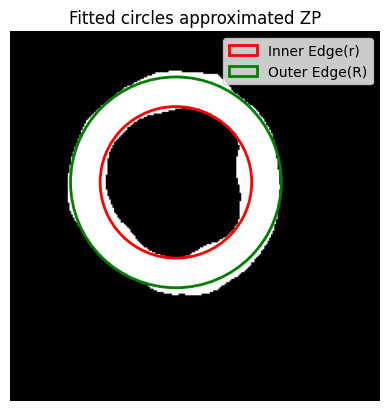

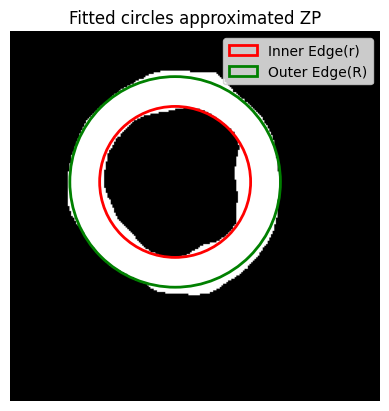

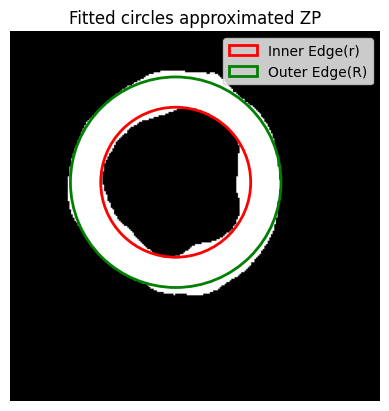

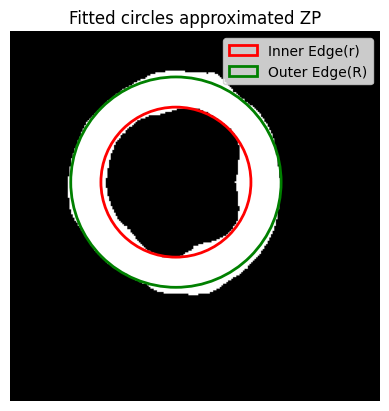

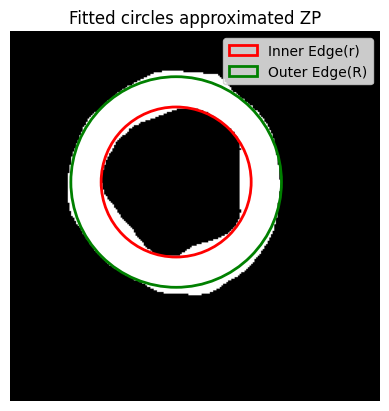

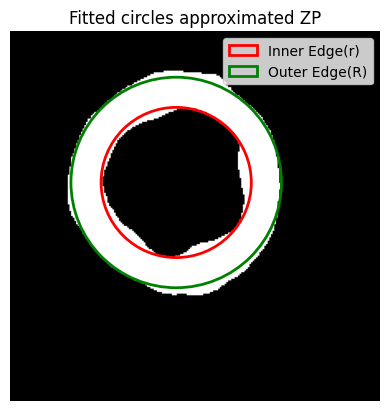

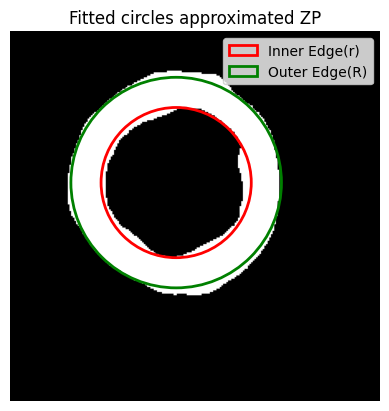

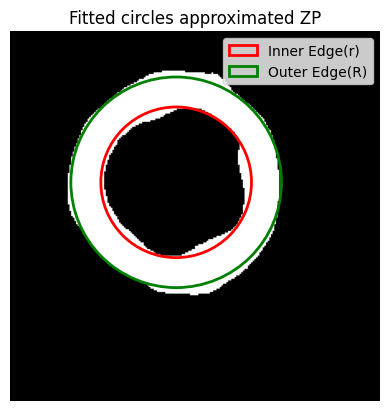

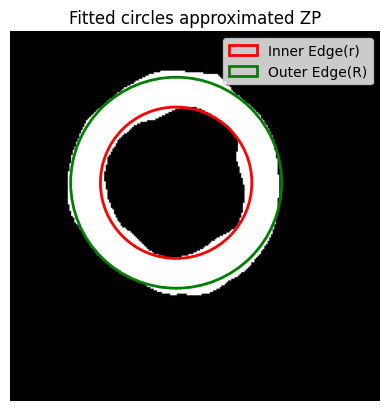

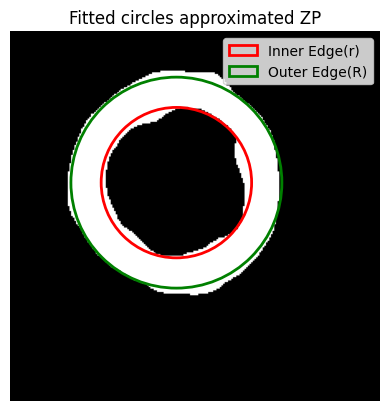

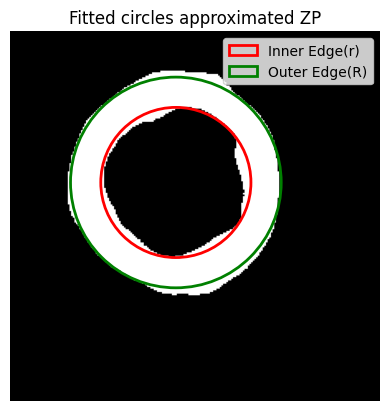

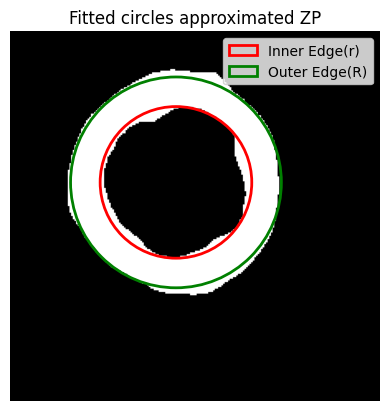

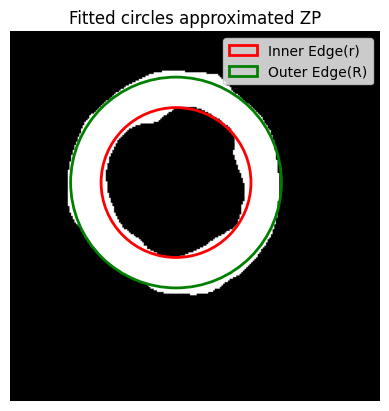

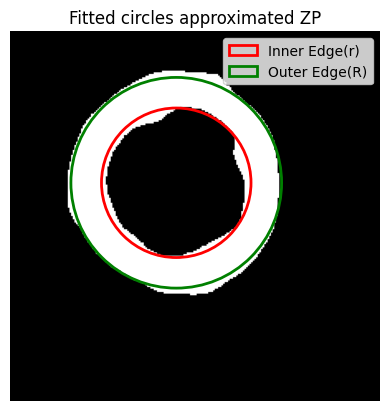

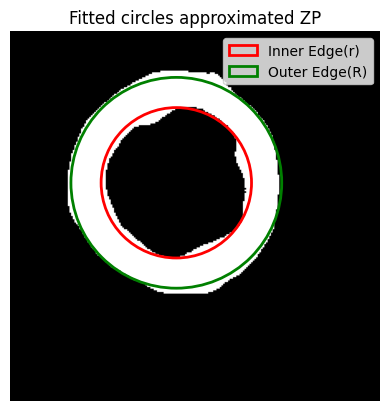

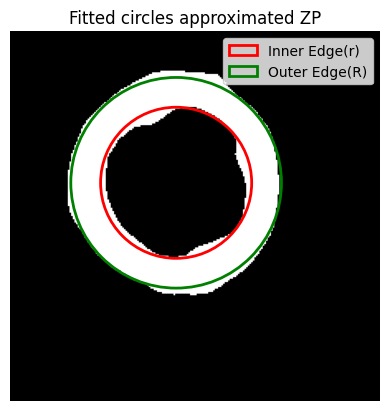

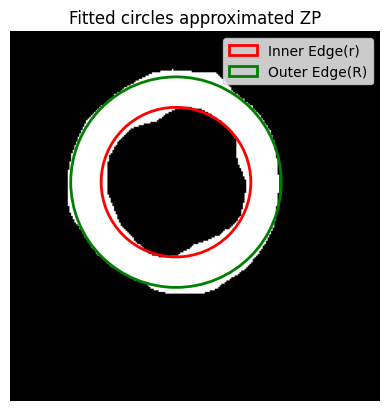

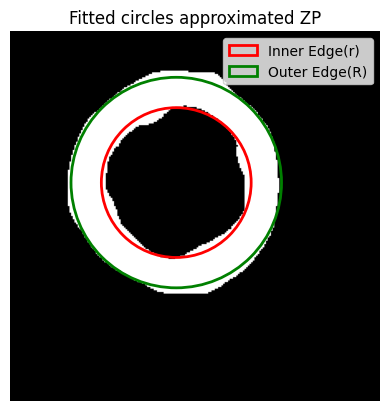

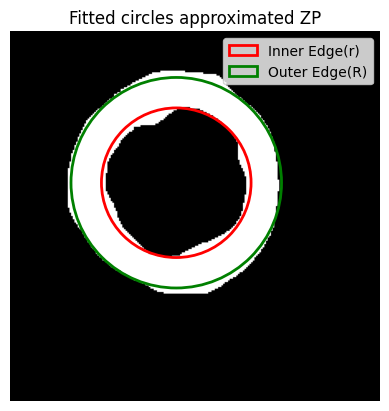

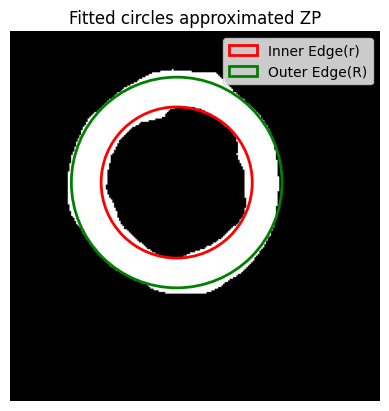

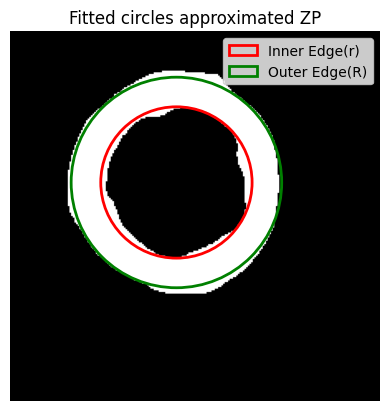

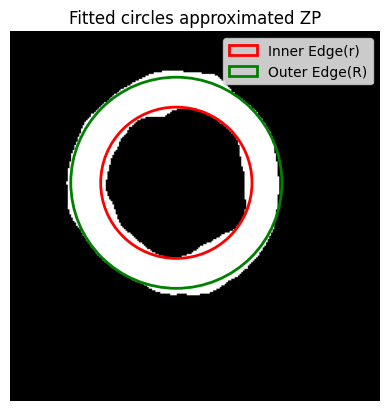

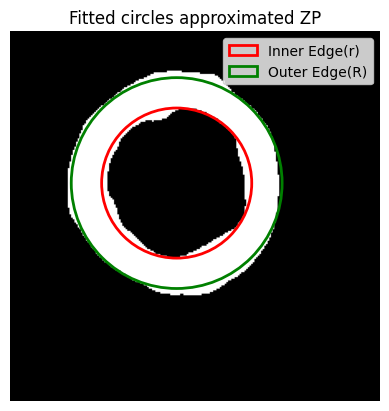

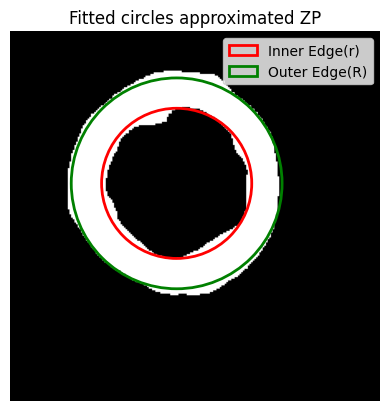

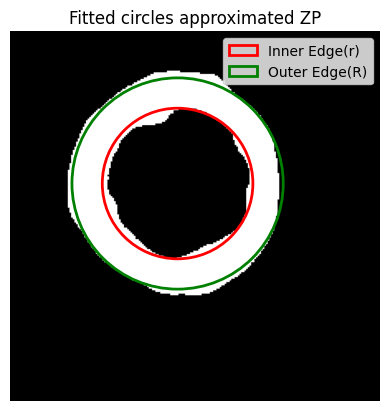

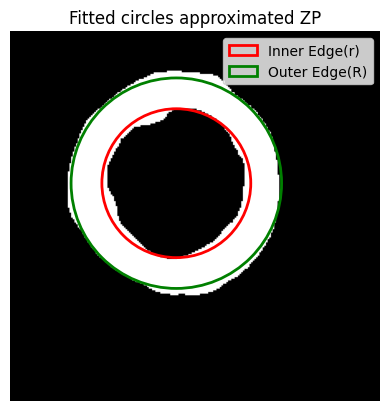

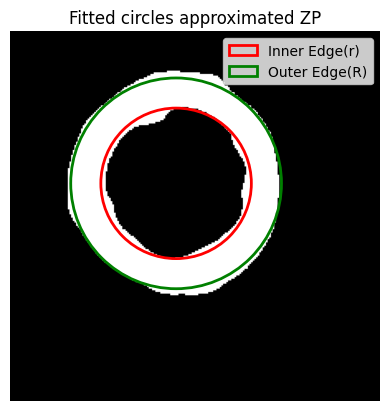

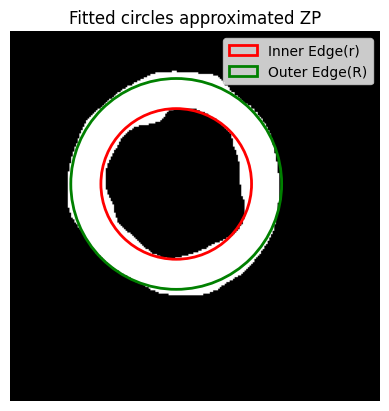

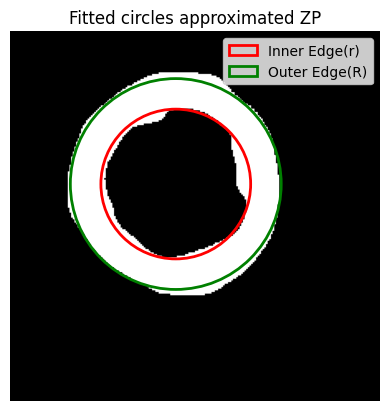

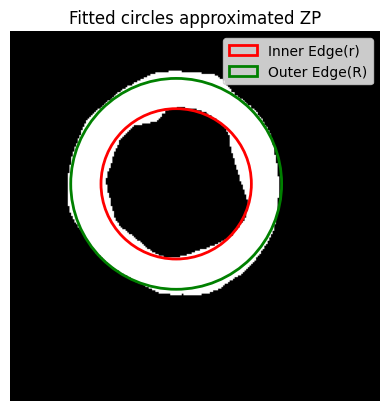

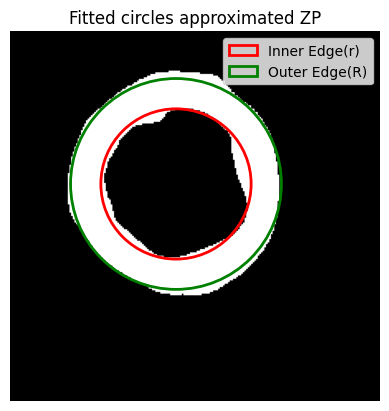

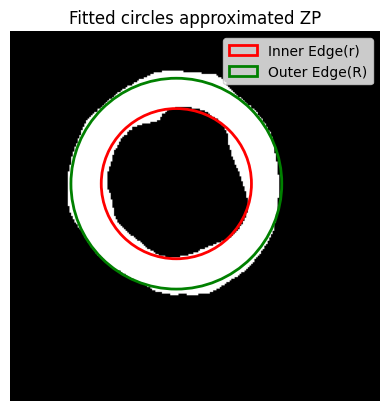

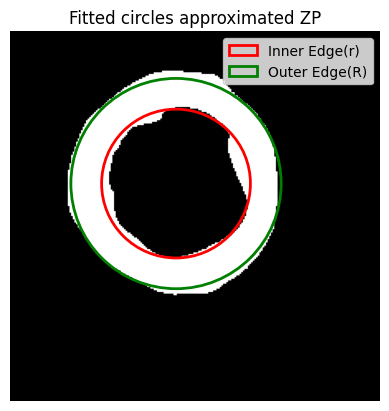

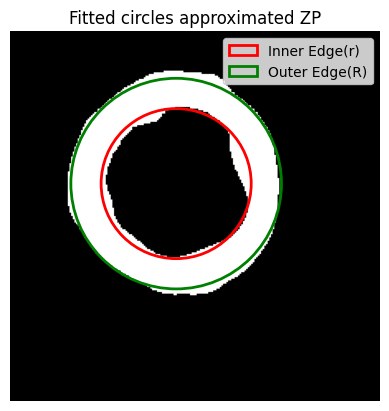

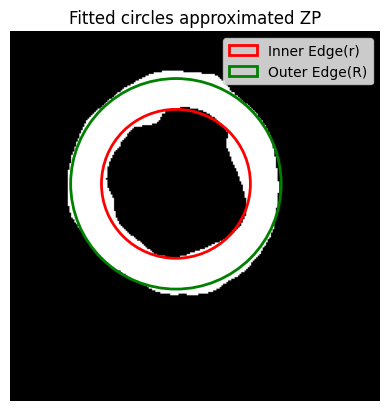

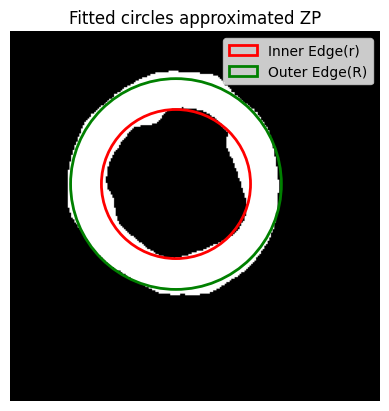

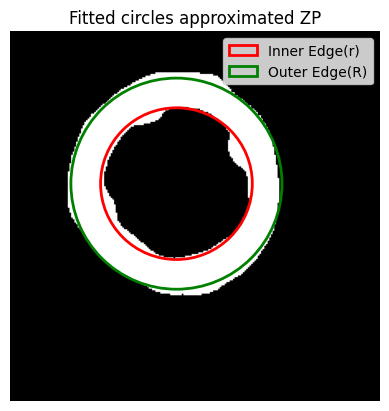

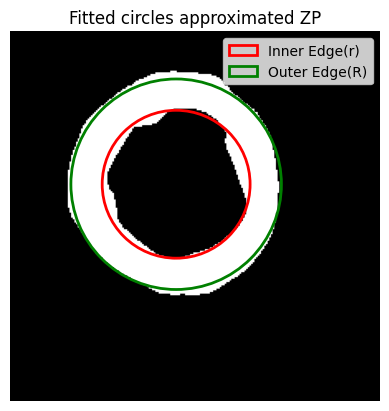

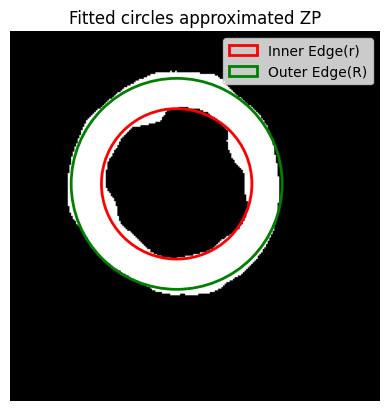

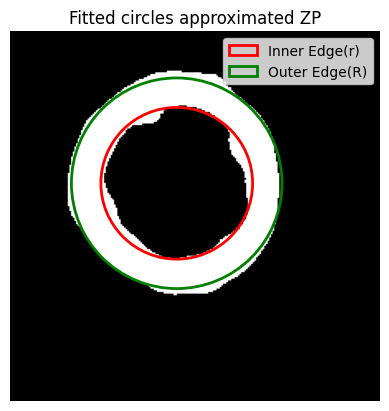

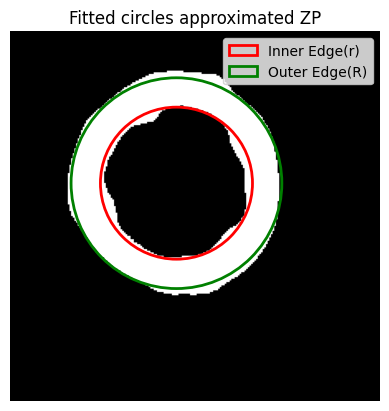

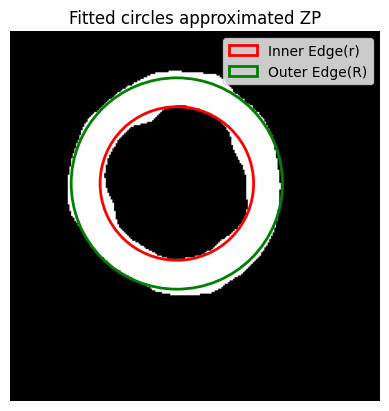

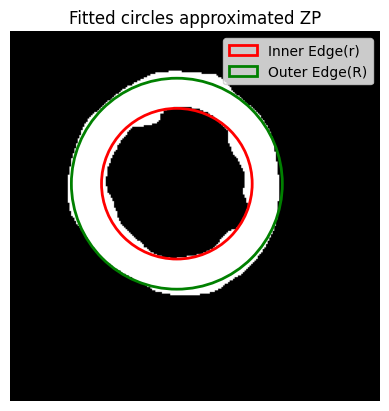

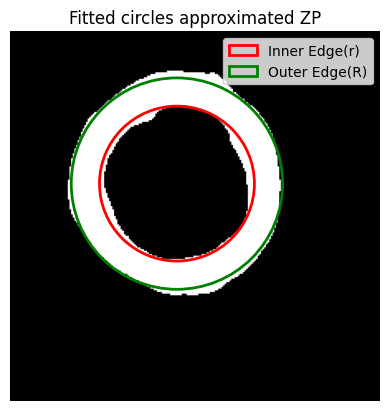

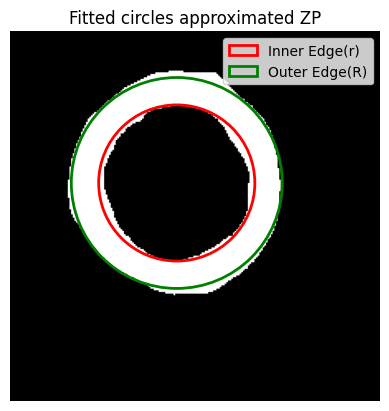

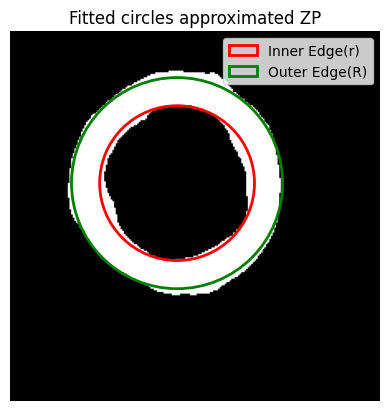

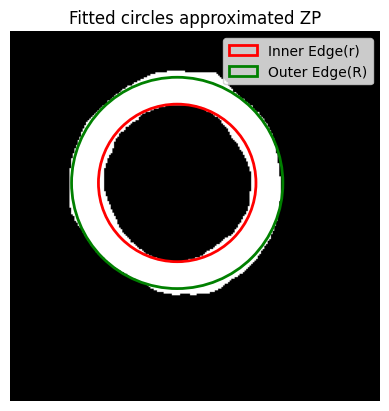

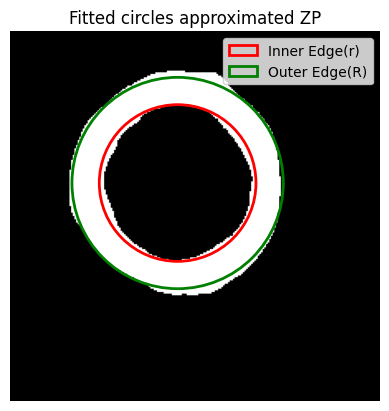

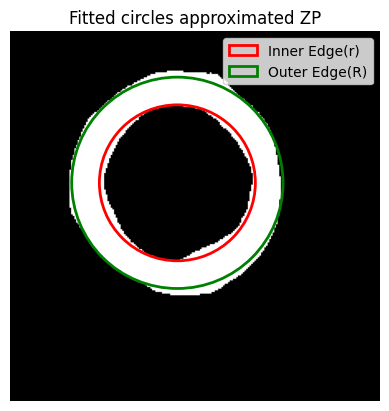

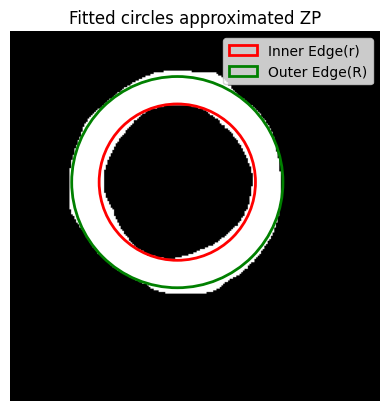

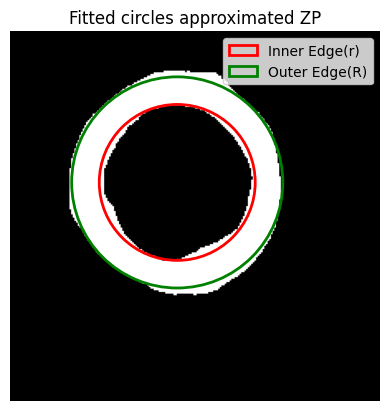

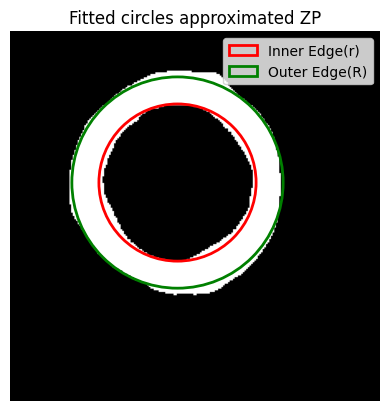

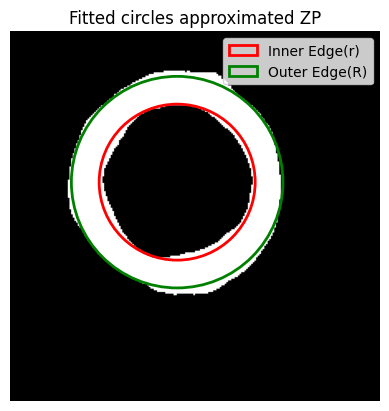

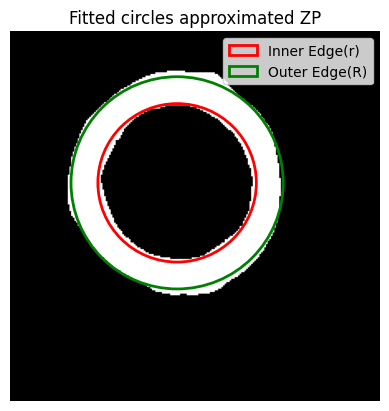

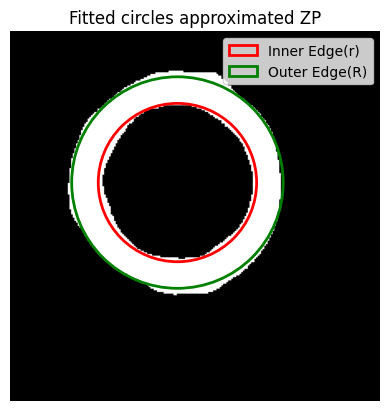

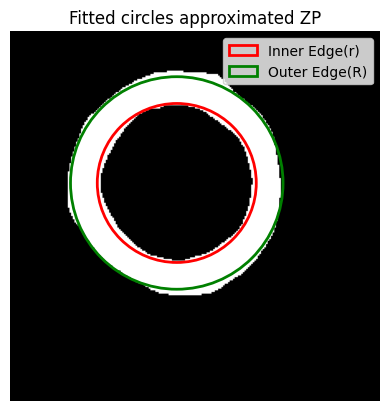

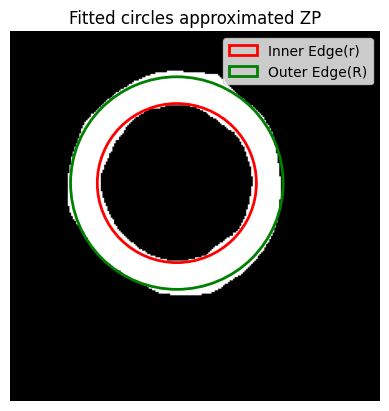

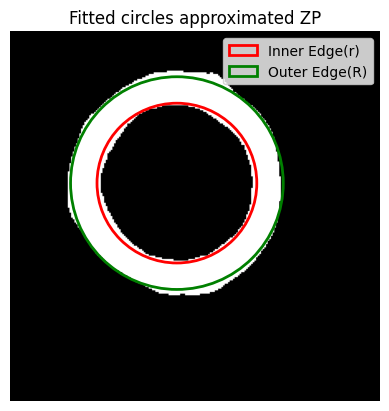

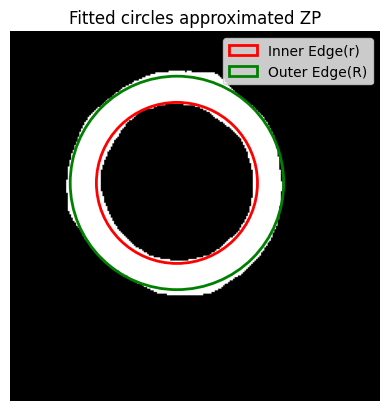

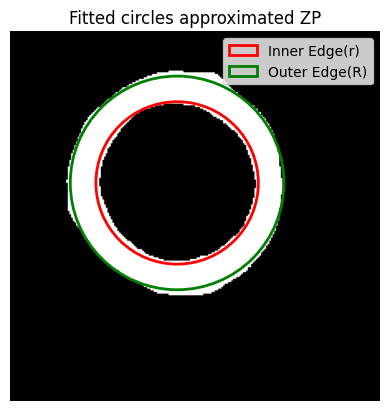

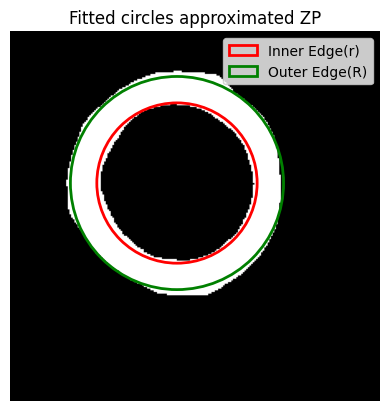

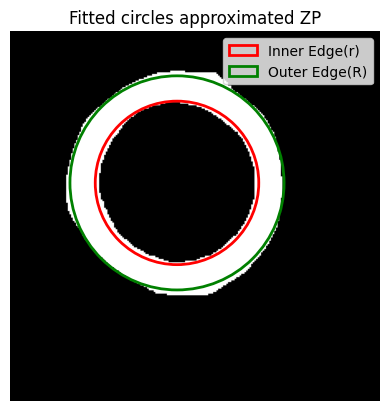

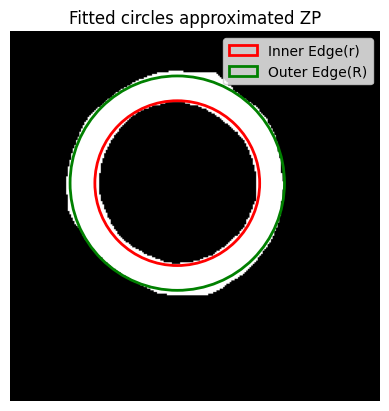

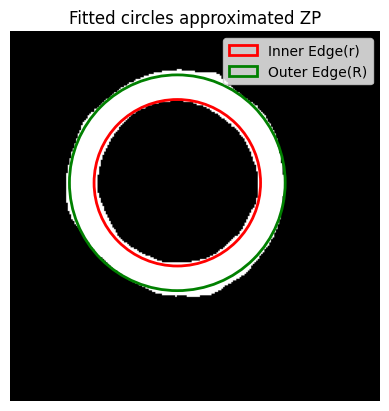

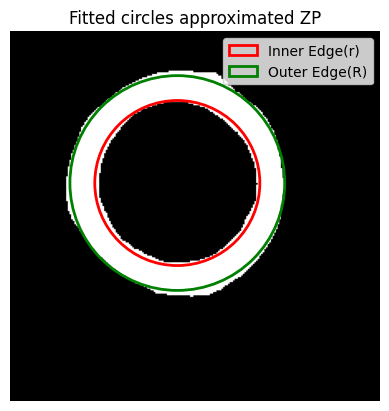

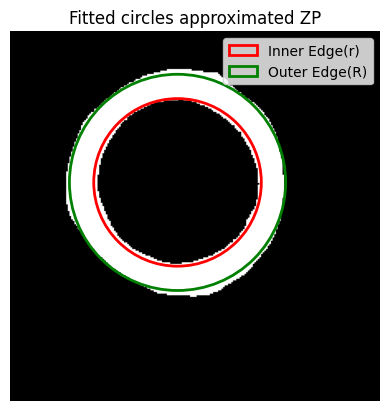

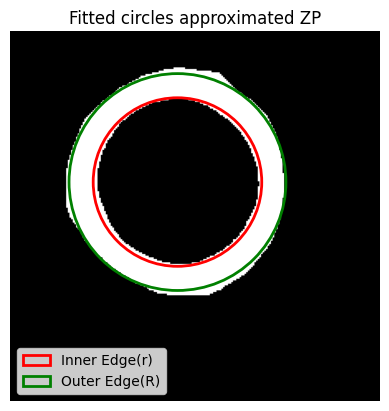

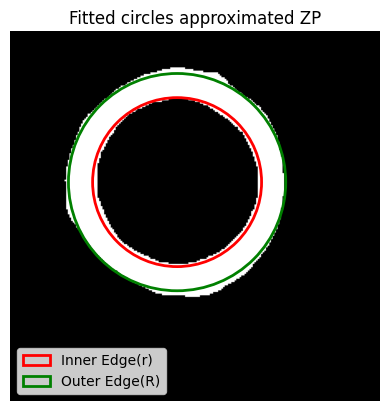

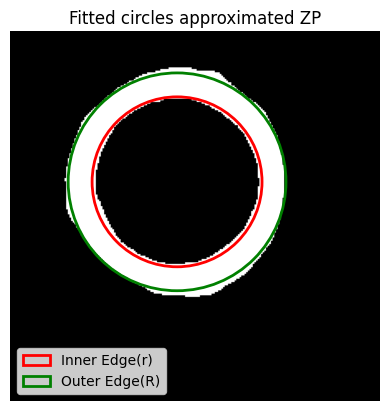

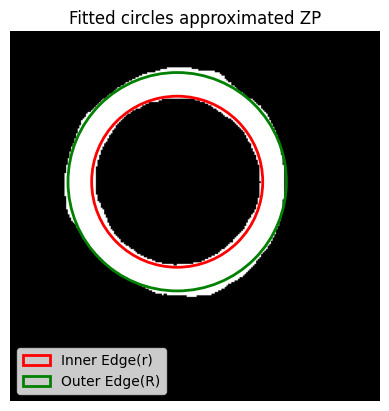

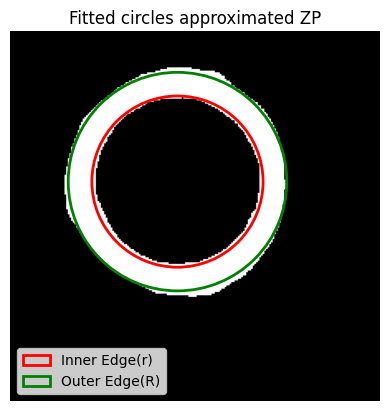

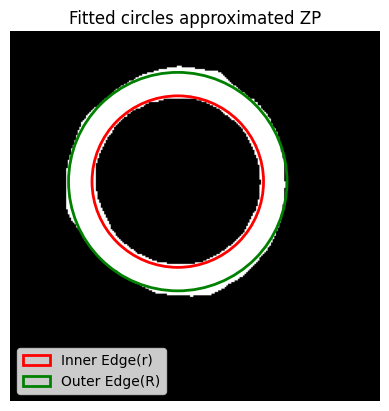

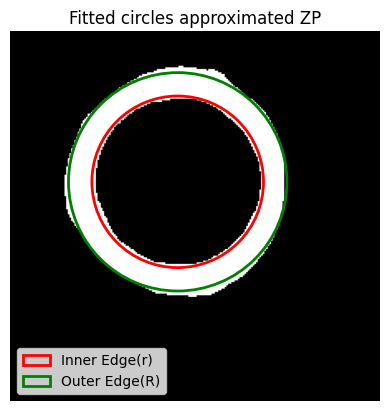

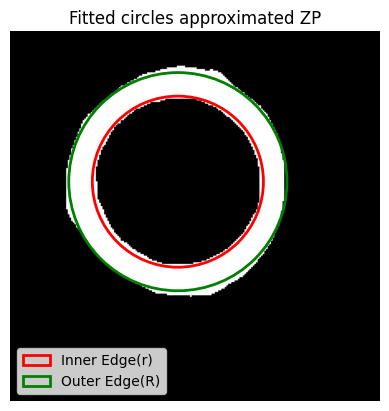

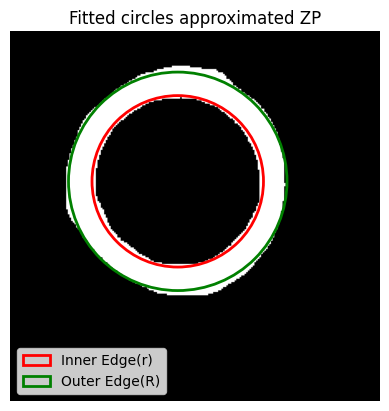

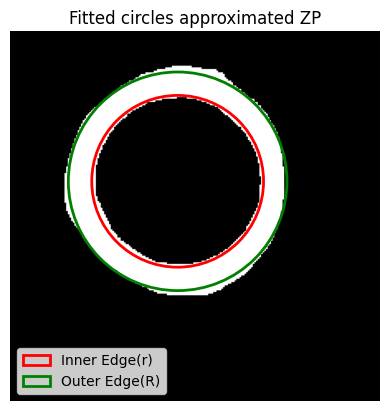

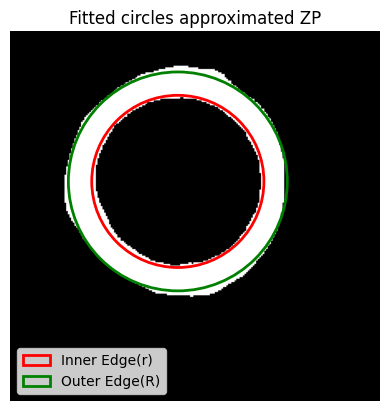

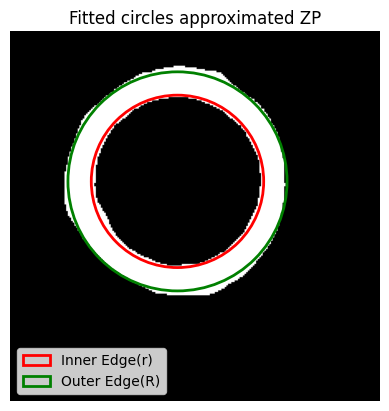

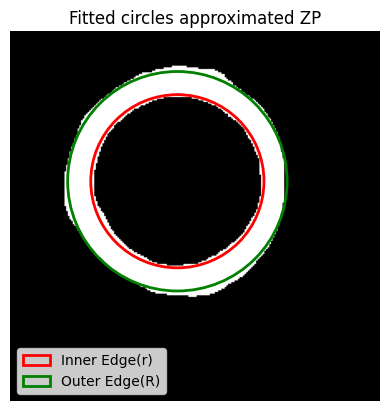

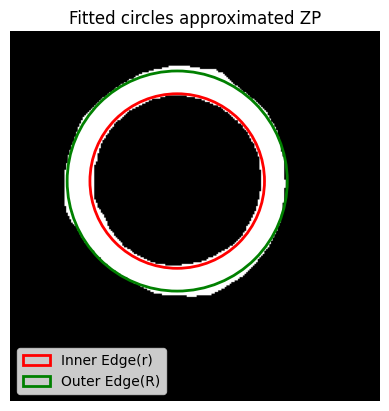

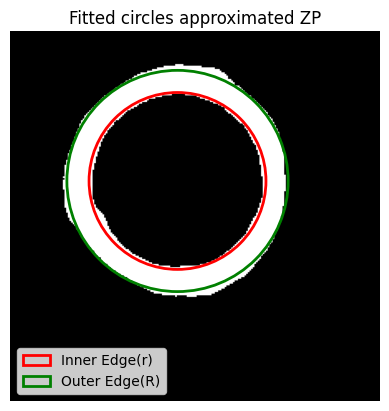

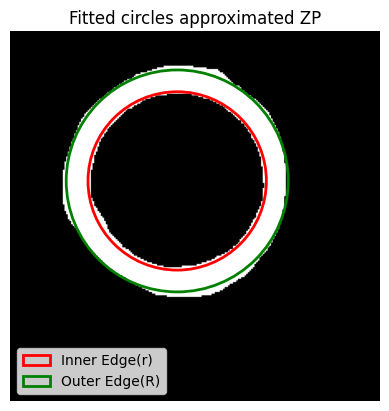

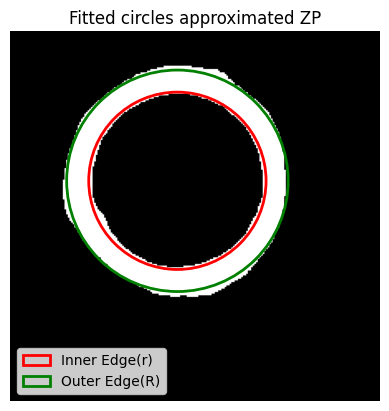

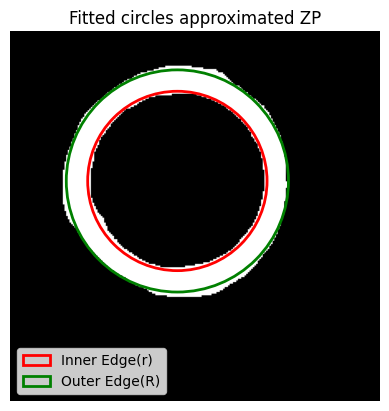

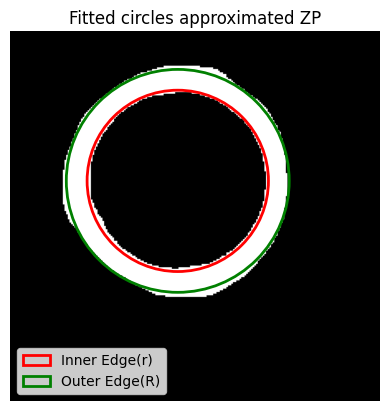

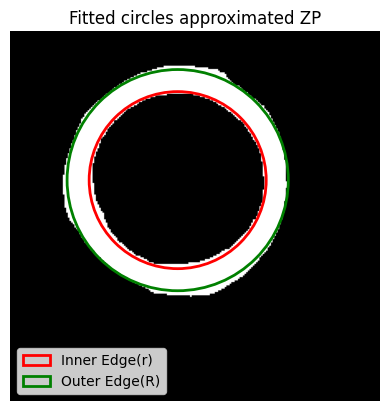

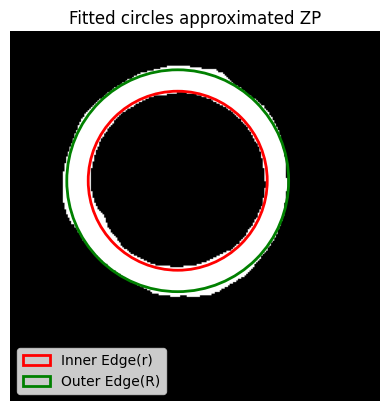

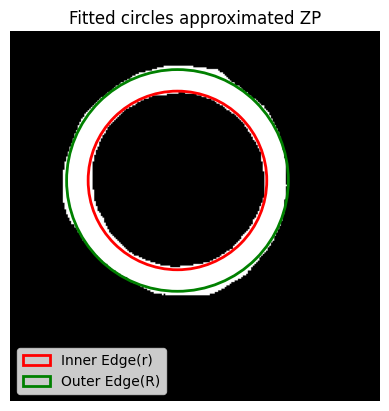

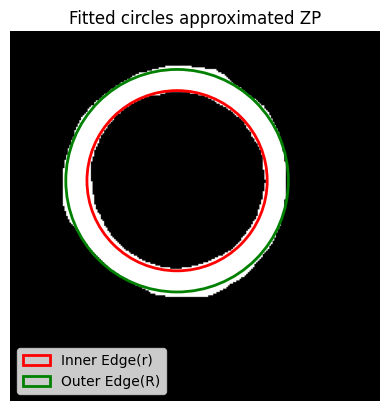

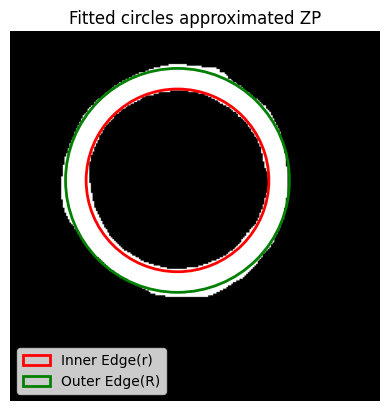

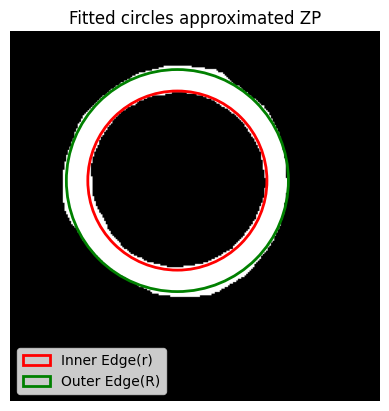

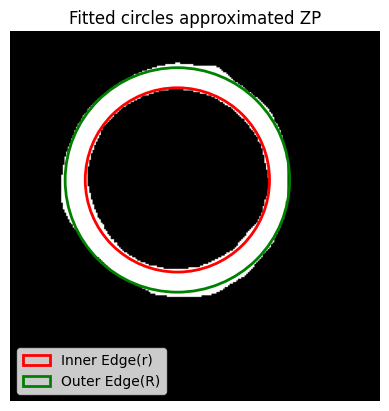

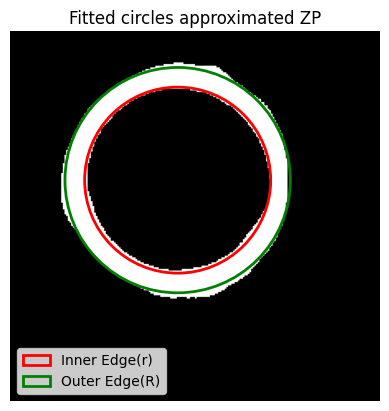

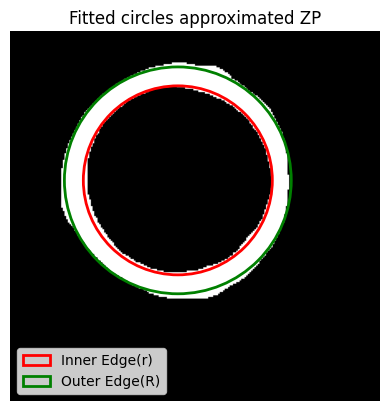

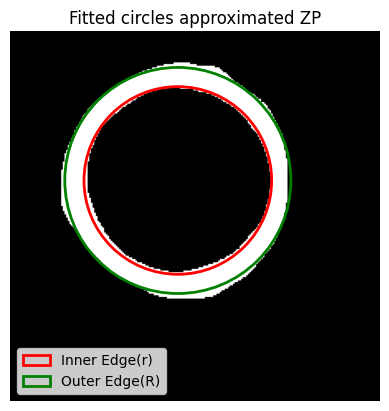

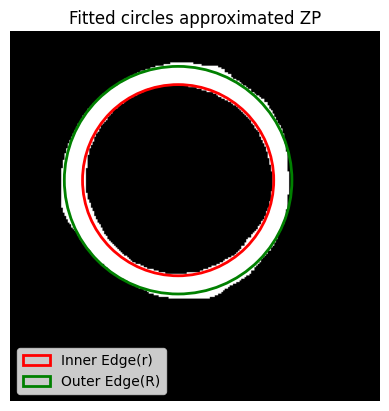

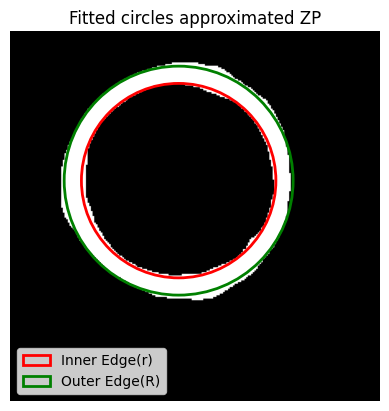

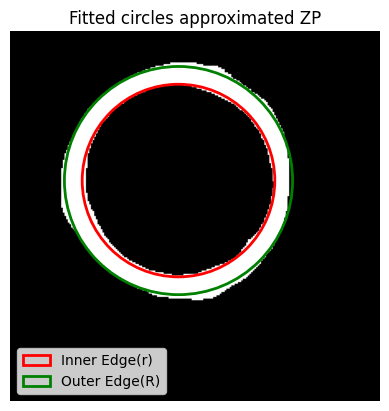

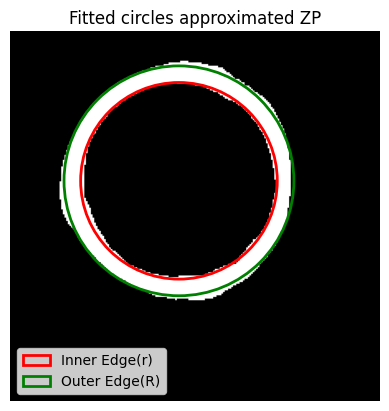

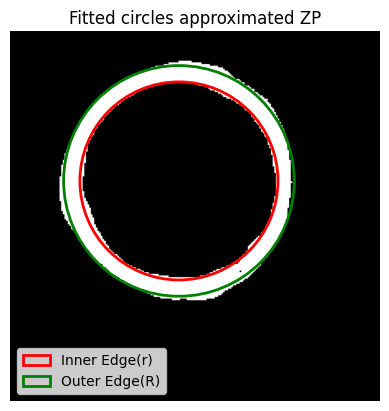

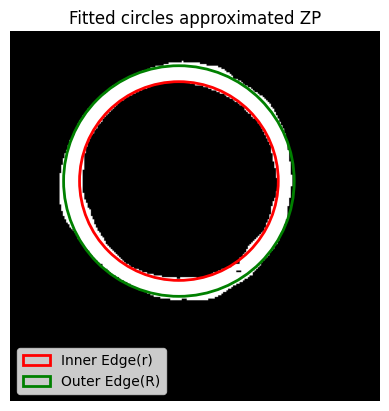

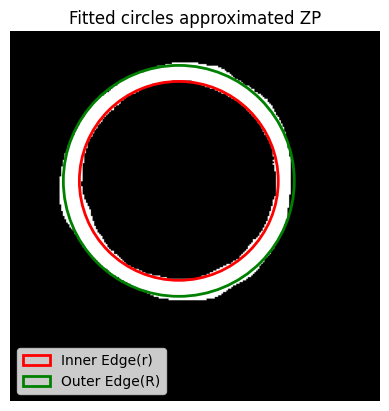

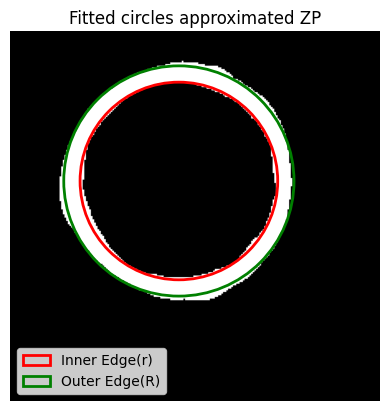

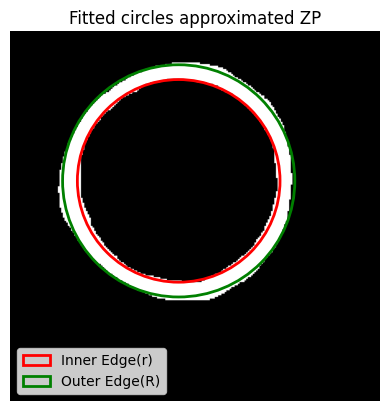

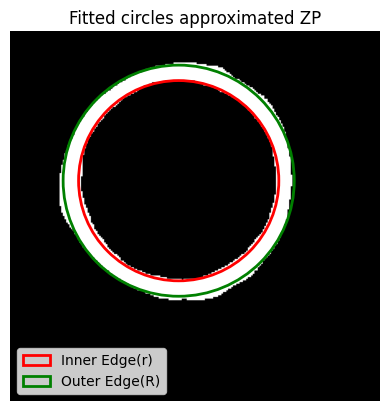

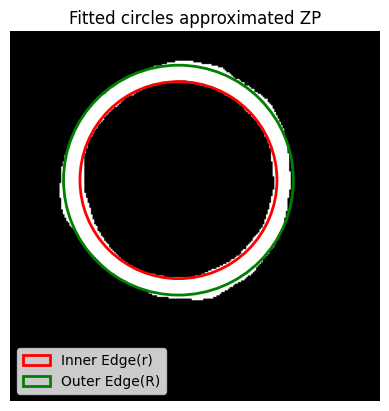

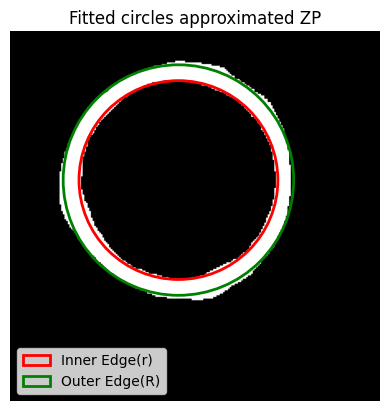

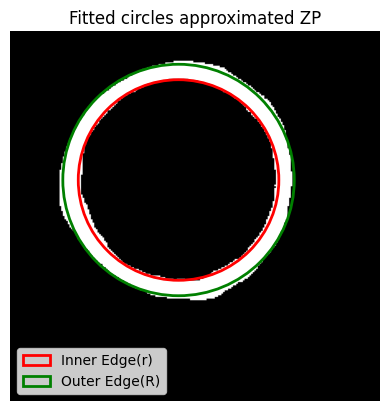

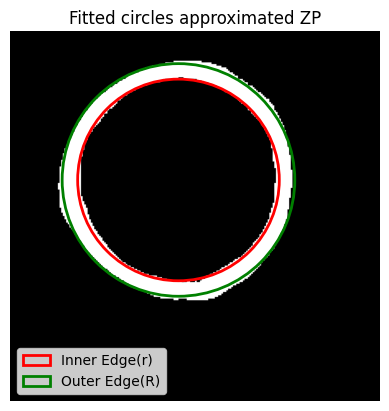

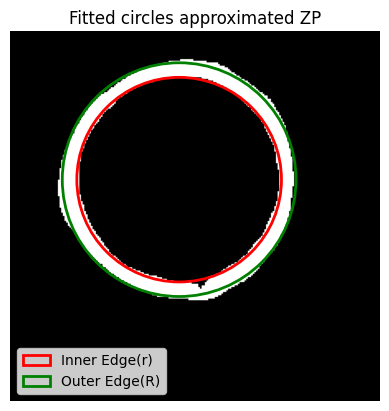

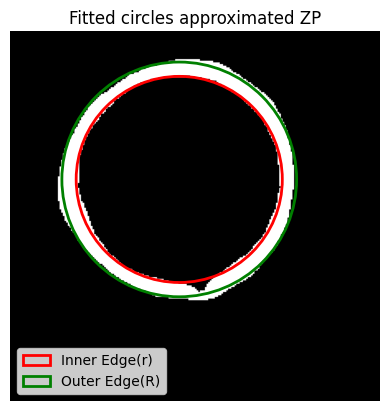

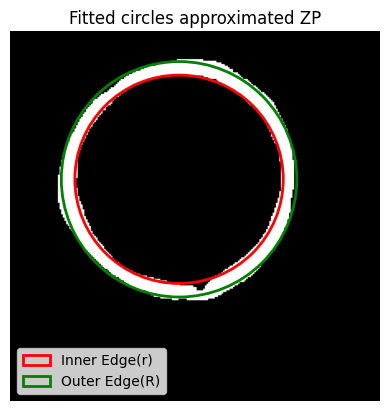

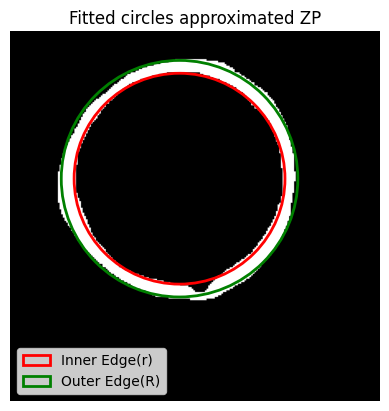

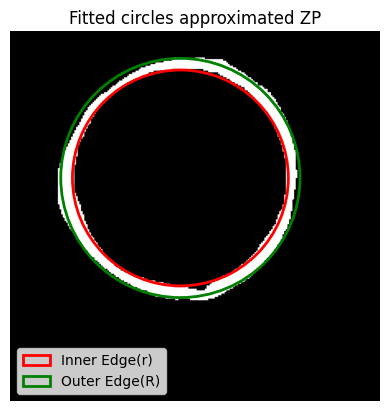

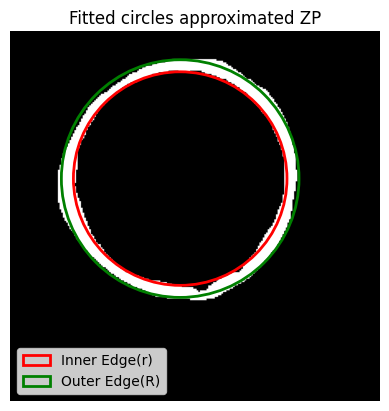

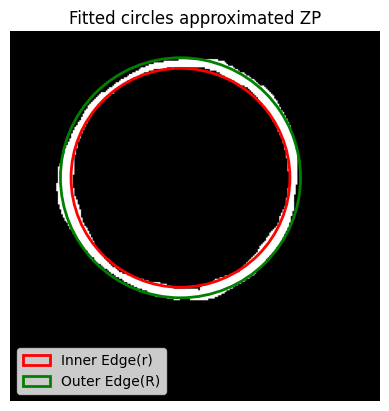

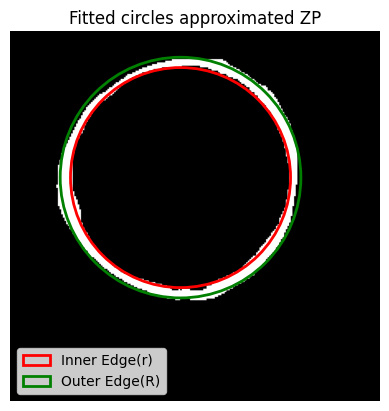

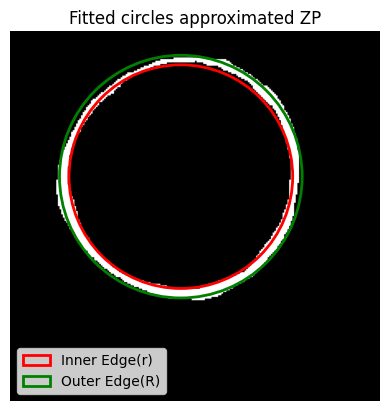

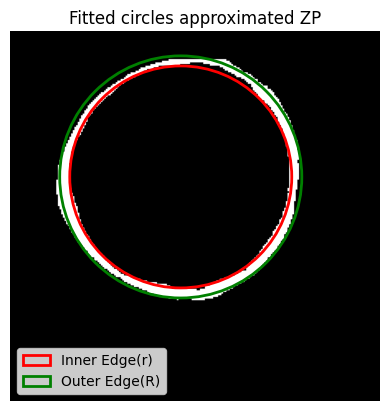

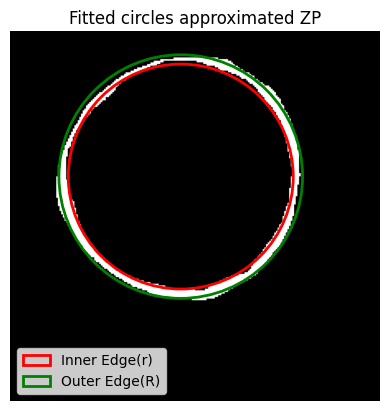

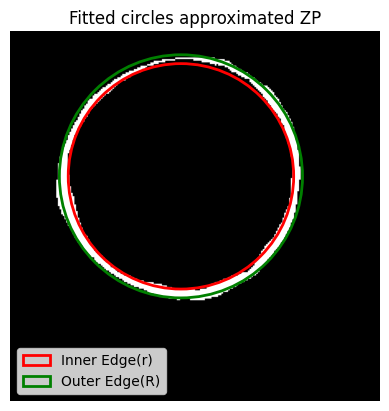

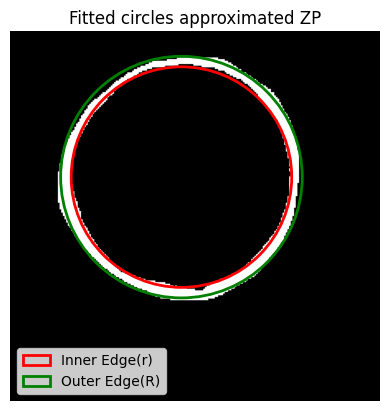

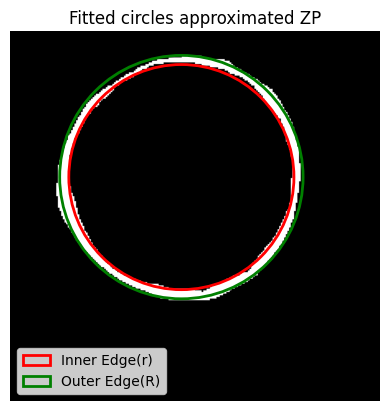

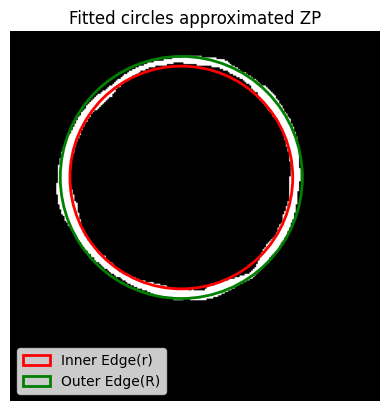

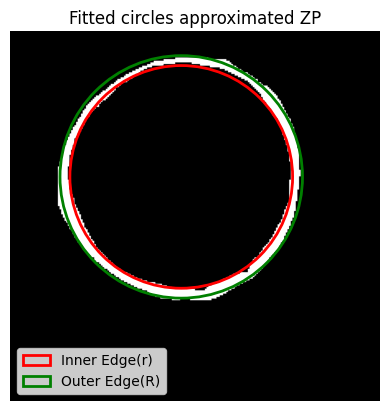

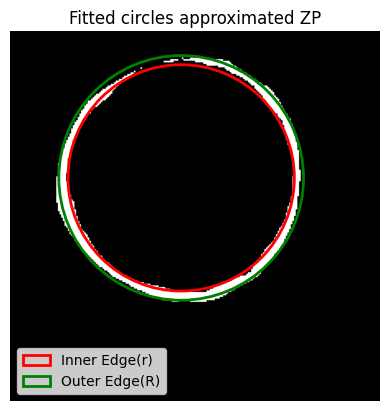

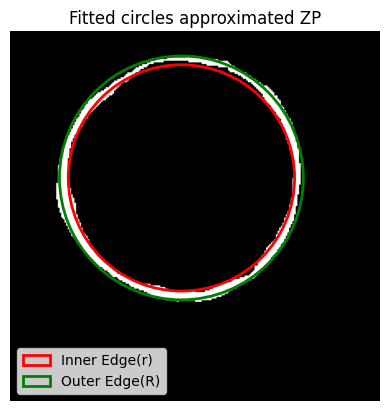

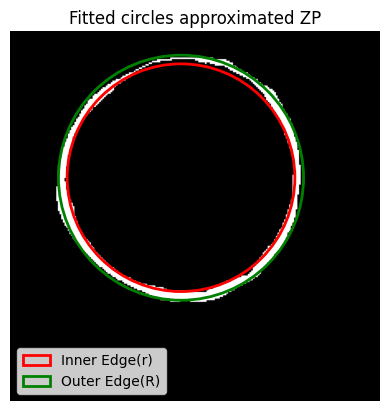

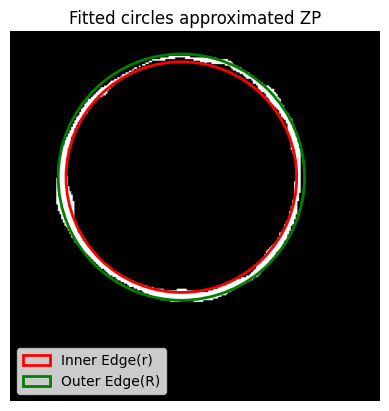

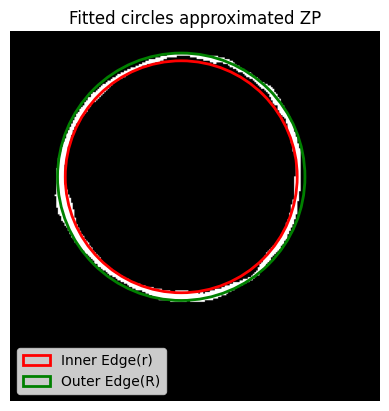

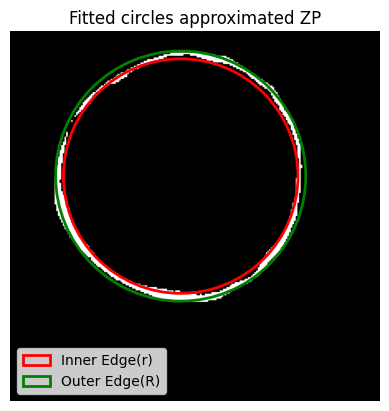

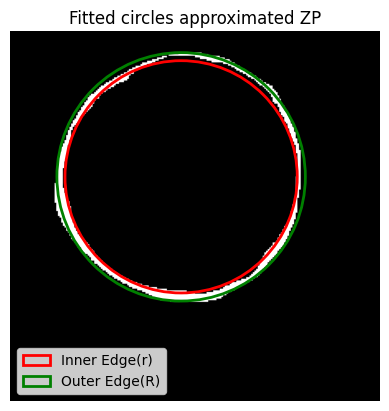

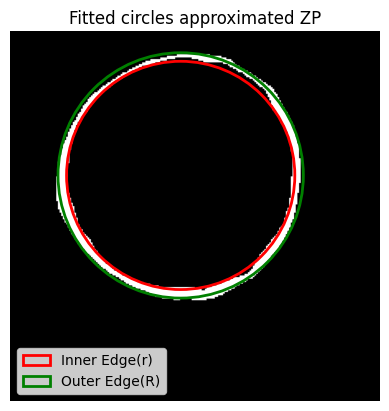

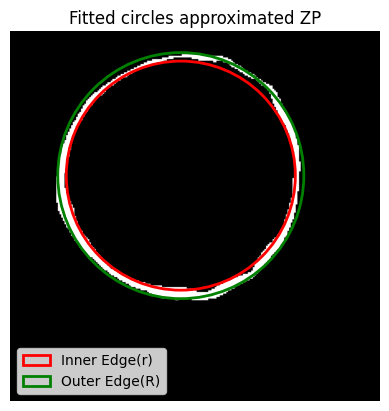

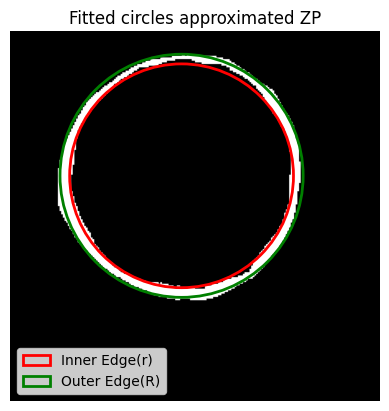

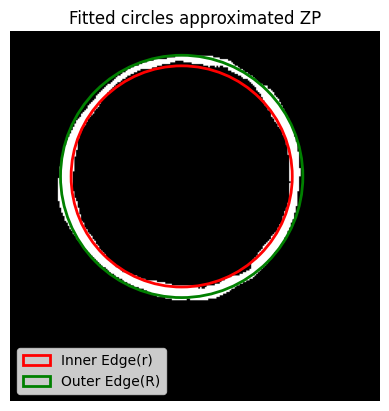

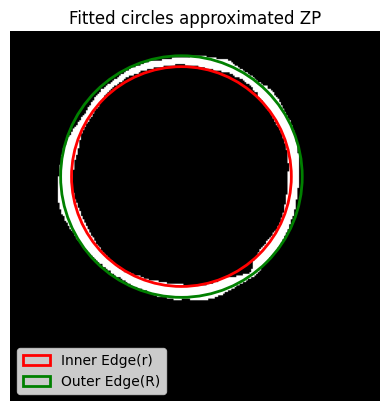

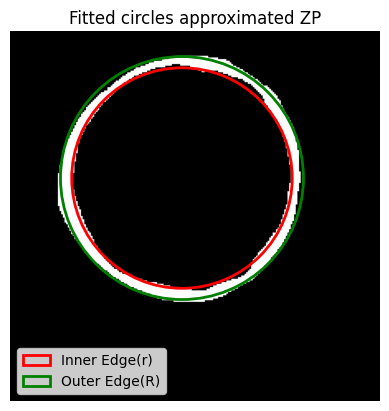

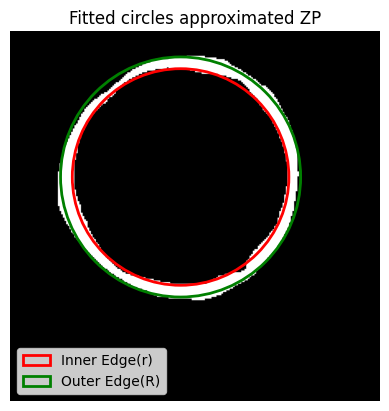

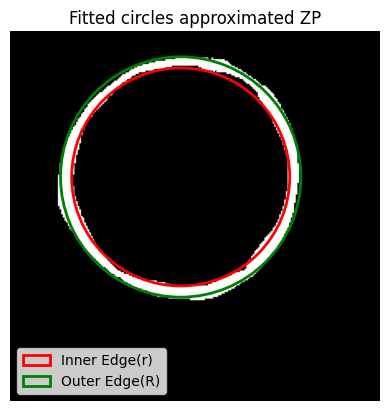

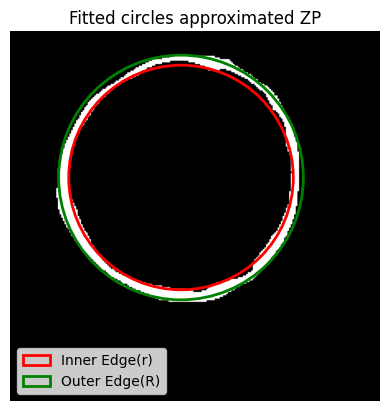

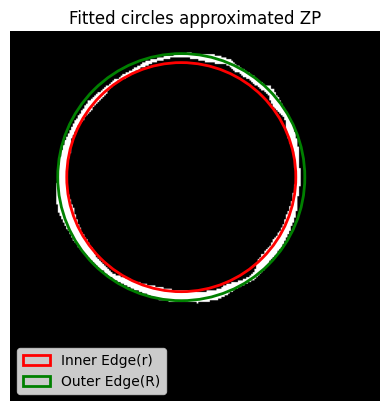

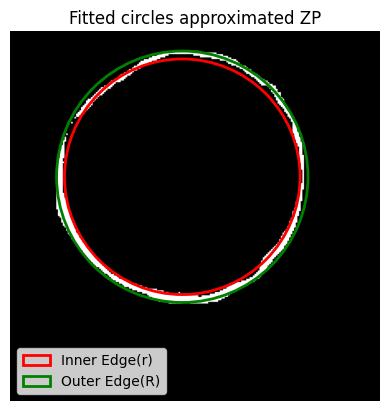

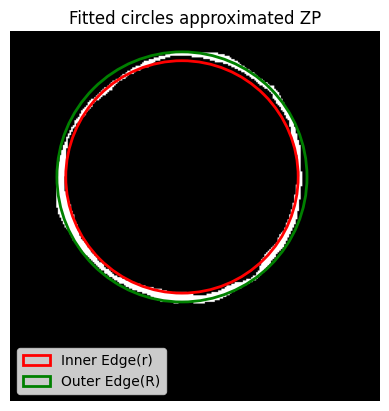

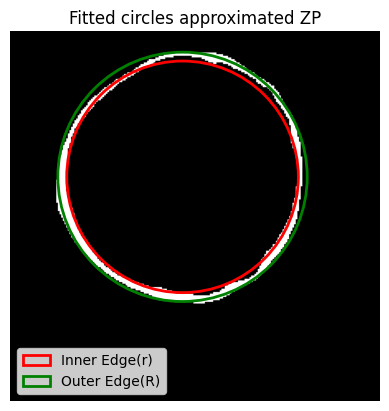

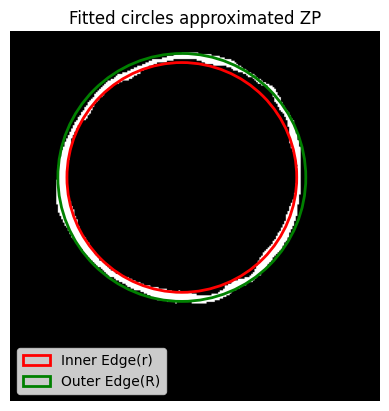

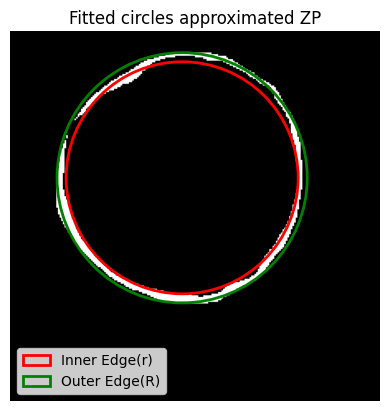

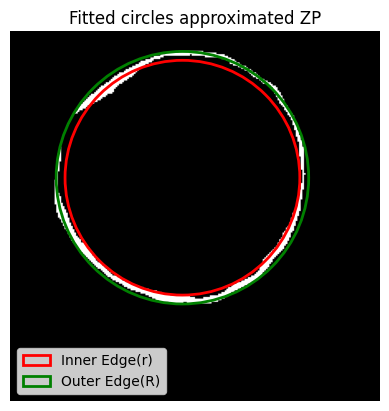

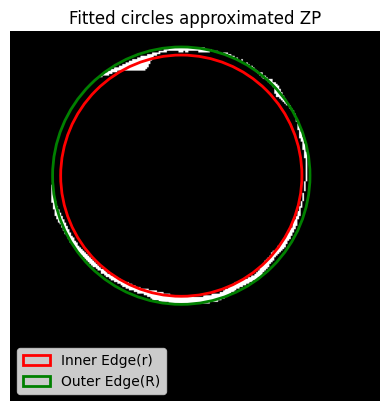

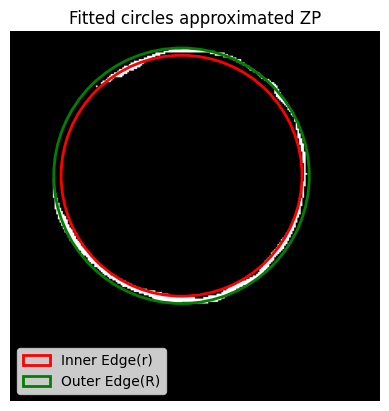

In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

# Example: Create a sample image (or load your own)

image = np.random.random((300, 300))
for i in range(nframes):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(all_masks[i][0]==1, cmap='gray')

    # Define the circle parameters: (x, y) center and radius
    circle = Circle(circle_centers[i], radius=radii[i], color='red', fill=False, linewidth=2)

    # Add the circle to the axes
    ax.add_patch(circle)
    circle = Circle(circle_centers[i], radius=outter_radii[i], color='green', fill=False, linewidth=2)

    # Add the circle to the axes
    ax.add_patch(circle)

    # Optional: Turn off the axis for a cleaner look
    ax.axis('off')
    plt.title("Fitted circles approximated ZP")
    
    plt.legend(["Inner Edge(r)", "Outer Edge(R)"])
    # Show the plot
    plt.show()


In [33]:
sample_pth

PosixPath('../../data/extracted_masks/D2018.04.14_S01766_I0149_D_9')

In [34]:
def sphere_volume(r):
    return 4*np.pi*r**3/3

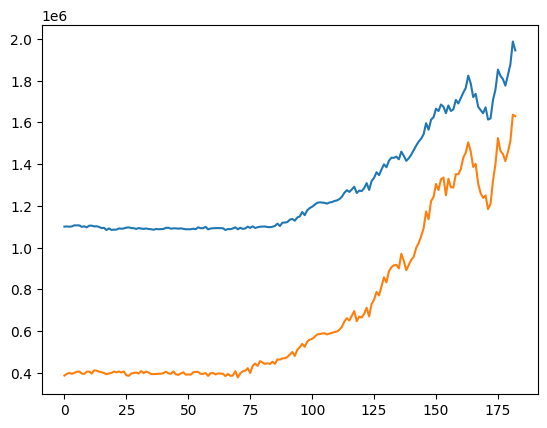

In [35]:
plt.plot(sphere_volume(np.array(outter_radii)))

plt.plot(sphere_volume(np.array(radii)))

In [53]:

volume = sphere_volume(np.array(outter_radii)) - sphere_volume(np.array(radii))
volume_norm = (volume-volume.min())/(volume.max()-volume.min())


area_norm = (np.array(area)- np.min(area))/(np.max(area)- np.min(area))

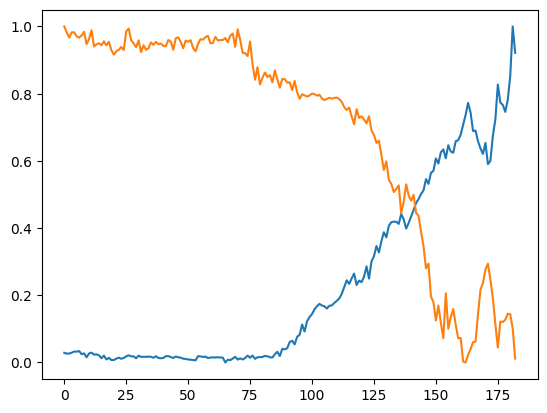

In [59]:
    plt.plot(area_norm)
    plt.plot(volume_norm)

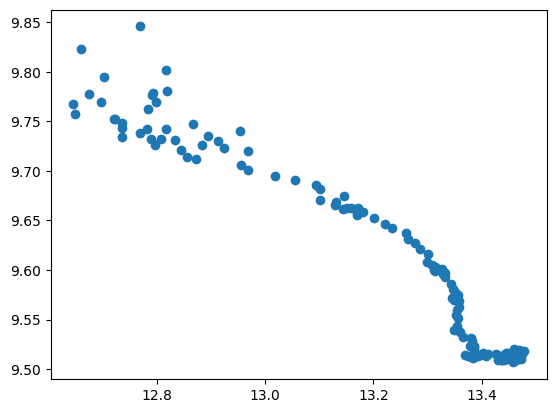

In [64]:
plt.scatter(np.log(volume), np.log(area))

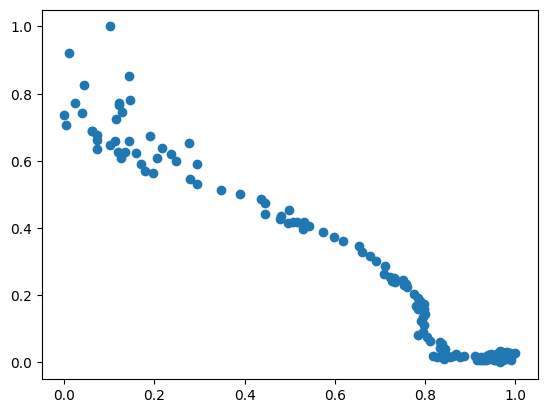

In [61]:
plt.scatter(volume_norm, area_norm)

Text(0, 0.5, 'Volume')

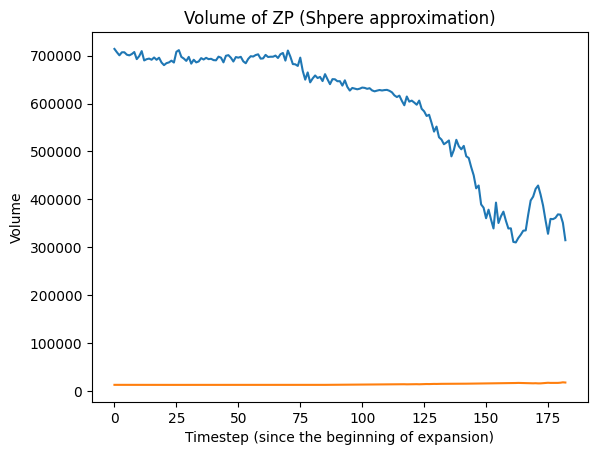

In [47]:
plt.plot(sphere_volume(np.array(outter_radii)) - sphere_volume(np.array(radii)))
plt.plot(area)
plt.title("Volume of ZP (Shpere approximation)")
plt.xlabel("Timestep (since the beginning of expansion)")
plt.ylabel("Volume")


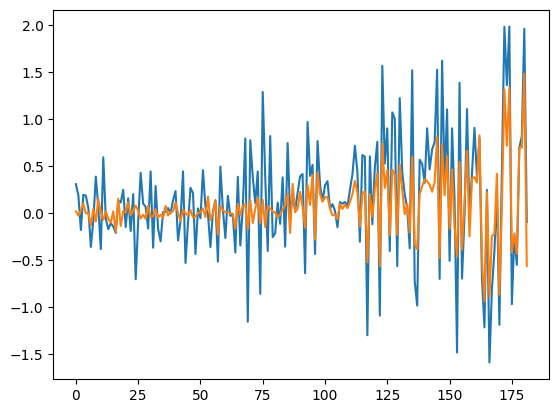

In [37]:
plt.plot(np.diff(radii))
plt.plot(np.diff(outter_radii))


In [38]:
457-100

357

In [39]:
sample_pth

PosixPath('../../data/extracted_masks/D2018.04.14_S01766_I0149_D_9')

Text(0, 0.5, 'Thickness')

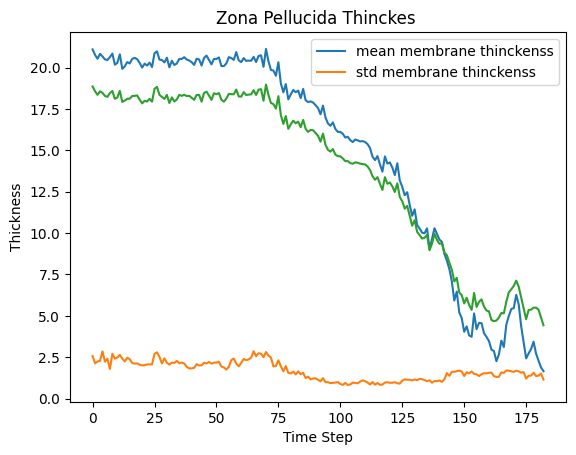

In [40]:
plt.plot(mean_thicknesses)
plt.plot(np.array(outter_radii)-np.array(radii))
plt.title('Zona Pellucida Thinckes ')
plt.legend(('mean membrane thinckenss','std membrane thinckenss'))
plt.xlabel('Time Step')
plt.ylabel('Thickness')

In [148]:
def calculate_stress(p: float, R:float, h: float) -> float:

    """
    p: float -> The pressure inisde the blastocyst
    R: float -> The radius of the blastocyst
    h: float -> the thickness of the ZP
    """
    
    return 2*p*R/(2*h)


def calculate_strain(h0: float, h: float) -> float:
    return (h0-h)/h0



def pressure_growth(p0: float, a: float, time_vector: np.ndarray) -> np.ndarray:

    return p0*(1+a*time_vector)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and Parameters
R_gas = 8.314  # Universal gas constant (J/(mol*K))
T = 310  # Temperature in Kelvin (approx. 37°C)
k = 1e-2  # Permeability constant (arbitrary units)
P_osmotic = 3.0  # Osmotic pressure (kPa)
n_solute = 0.01  # Number of moles of solute (mol)
h0 = 10  # Initial thickness of ZP (microns)
E = 18  # Young's modulus (kPa)
h_min = 1  # Minimum allowable thickness (microns)
V0 = 1e3  # Initial blastocoel volume (microns^3)
dt = 0.1  # Time step (arbitrary units)
timesteps = 100  # Number of timesteps

# Initialize Variables
time = np.linspace(0, timesteps * dt, timesteps)
P = np.zeros(timesteps)  # Pressure in kPa
V = np.zeros(timesteps)  # Volume in microns^3
R = np.zeros(timesteps)  # Radius of the blastocoel (microns)
h = np.zeros(timesteps)  # Thickness of ZP (microns)
strain = np.zeros(timesteps)
stress = np.zeros(timesteps)

# Initial Conditions
P[0] = 0.1  # Initial pressure (kPa)
V[0] = V0
R[0] = (3 * V0 / (4 * np.pi))**(1/3)  # Initial radius of the blastocoel
h[0] = h0

# Time Evolution
for t in range(1, timesteps):
    # Fluid influx and volume update
    Q_in = k * (P_osmotic - P[t-1])  # Fluid influx rate
    V[t] = V[t-1] + Q_in * dt  # Update volume
    R[t] = (3 * V[t] / (4 * np.pi))**(1/3)  # Update radius

    # Stress calculation
    strain[t] = (h0 - h[t-1]) / h0
    stress[t] = E * strain[t]

    # Pressure update
    P[t] = (n_solute * R_gas * T) / V[t]

    # Thickness update (Laplace's law)
    h[t] = max((2 * stress[t] * R[t]) / P[t], h_min)  # Ensure h >= h_min

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(time, P[10:], label="Pressure (kPa)", lw=2)
# plt.plot(time, h, label="ZP Thickness (microns)", lw=2)
# plt.plot(time, R, label="Radius (microns)", lw=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Values")
plt.title("Blastocyst Expansion Dynamics")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time, stress, label="Stress (kPa)", lw=2)
plt.plot(time, strain, label="Strain", lw=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Values")
plt.title("Stress and Strain Dynamics")
plt.legend()
plt.grid()
plt.show()


In [ ]:
plt.plot(P[20:])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and Parameters
R_gas = 8.314  # Universal gas constant (J/(mol*K))
T = 310  # Temperature in Kelvin (approx. 37°C)
k = 1e-2  # Permeability constant (arbitrary units)
P_osmotic = 3.0  # Osmotic pressure (kPa)
n_solute = 0.01  # Number of moles of solute (mol)
h0 = 10  # Initial thickness of ZP (microns)
E0 = 18  # Initial Young's modulus (kPa)
E_growth_rate = 0.01  # Growth rate of Young's modulus per timestep
h_min = 1  # Minimum allowable thickness (microns)
V0 = 1e3  # Initial blastocoel volume (microns^3)
dt = 0.1  # Time step (arbitrary units)
timesteps = 100  # Number of timesteps

# Initialize Variables
time = np.linspace(0, timesteps * dt, timesteps)
P = np.zeros(timesteps)  # Pressure in kPa
V = np.zeros(timesteps)  # Volume in microns^3
R = np.zeros(timesteps)  # Radius of the blastocoel (microns)
h = np.zeros(timesteps)  # Thickness of ZP (microns)
strain = np.zeros(timesteps)
stress = np.zeros(timesteps)
E = np.zeros(timesteps)  # Dynamic Young's modulus (kPa)

# Initial Conditions
P[0] = 0.1  # Initial pressure (kPa)
V[0] = V0
R[0] = (3 * V0 / (4 * np.pi))**(1/3)  # Initial radius of the blastocoel
h[0] = h0
E[0] = E0

# Time Evolution
for t in range(1, timesteps):
    # Update Young's modulus with growth rate
    E[t] = E[t-1] * (1 + E_growth_rate)

    # Fluid influx and volume update
    Q_in = k * (P_osmotic - P[t-1])  # Fluid influx rate
    V[t] = V[t-1] + Q_in * dt  # Update volume
    R[t] = (3 * V[t] / (4 * np.pi))**(1/3)  # Update radius

    # Stress calculation
    strain[t] = (h0 - h[t-1]) / h0
    stress[t] = E[t] * strain[t]

    # Pressure update
    P[t] = (n_solute * R_gas * T) / V[t]

    # Thickness update (Laplace's law)
    h[t] = max((2 * stress[t] * R[t]) / P[t], h_min)  # Ensure h >= h_min

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(time, P, label="Pressure (kPa)", lw=2)
plt.plot(time, h, label="ZP Thickness (microns)", lw=2)
plt.plot(time, R, label="Radius (microns)", lw=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Values")
plt.title("Blastocyst Expansion Dynamics")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time, stress, label="Stress (kPa)", lw=2)
plt.plot(time, strain, label="Strain", lw=2)
plt.plot(time, E, label="Young's Modulus (kPa)", lw=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Values")
plt.title("Stress, Strain, and Young's Modulus Dynamics")
plt.legend()
plt.grid()
plt.show()


In [144]:
E_mu = 18
E_sigma = 2

R  = np.array(radii)
h0 = mean_thicknesses[0][0]
hs = h0 - np.array([m[0] for m in mean_thicknesses])#[1:]

ok_hs = hs>0

E_sample = np.random.normal(E_mu, E_sigma, (50,1000))

In [145]:
# Define a linear elastic model
def stress_strain_model(strain, E):
    return E * strain


In [ ]:
pressure_levels*R*hs

In [147]:
pressure_levels = pressure_growth(p0, a_mu, t_vec)

stress_levels = calculate_stress(
                                pressure_levels[:,None][ok_hs], R[:,None][ok_hs],
                                hs[:,None][ok_hs]
                                    )

strain = hs[ok_hs]/h0

In [ ]:
plt.plot(stress_levels)

In [151]:
def stress_strain_model(strain, E):
    return E * strain


In [152]:
predicted_stress = stress_strain_model(strain, E_mu)

predicted_stress[predicted_stress<1] =1


In [ ]:
plt.plot(predicted_stress)

In [ ]:
predicted_h = (pressure_levels * R[1:,None][ok_hs]) / (2 * predicted_stress[:,None])

In [ ]:
predicted_h

In [156]:
from sklearn.metrics import mean_squared_error

In [ ]:
mses  = []
for i in range(50):

    
    mse = mean_squared_error(strain[10:], ((h0-predicted_h)/h0)[10:,i])
    predicted_strain = (h0-predicted_h)/h0
    mses.append(mse)
    plt.plot(strain[10:])
    plt.plot(((h0-predicted_h)/h0)[10:,i])

    plt.title("True Strain vs Predicted Strain")
    plt.xlabel("time")
    plt.ylabel("strain")
    plt.legend(['True Strain', 'Predicted Strain'])
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data (replace these with your actual data)
time = np.linspace(0, 10, 100)  # Time steps
thickness = 15 * np.exp(-0.1 * time) + 0.5  # Simulated thinning process

# Neo-Hookean model for thickness
# h(t) = h0 * exp(-C1 * t)
def neo_hookean_model(t, h0, C1):
    return h0 * np.exp(-C1 * t)

# Initial guess for parameters: h0 (initial thickness), C1 (decay rate)
initial_guess = [thickness[0], 0.1]

# Curve fitting
params, covariance = curve_fit(neo_hookean_model, time, thickness, p0=initial_guess)

# Extract fitted parameters
h0_fitted, C1_fitted = params

# Generate fitted curve
fitted_thickness = neo_hookean_model(time, h0_fitted, C1_fitted)

# Plot original data and fitted curve
plt.figure(figsize=(8, 5))
plt.scatter(time, thickness, label="Observed Data", color="blue")
plt.plot(time, fitted_thickness, label=f"Fitted Model\n$h_0$={h0_fitted:.2f}, $C_1$={C1_fitted:.2f}", color="red")
plt.title("Neo-Hookean Model Fit")
plt.xlabel("Time")
plt.ylabel("Thickness")
plt.legend()
plt.grid()
plt.show()

# Print fitted parameters
print(f"Fitted parameters:\n h0 (initial thickness) = {h0_fitted:.4f}\n C1 (decay rate) = {C1_fitted:.4f}")
plt.plot(pressure_levels, mses)